In [40]:
import numpy as np
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, concatenate, BatchNormalization, Lambda, Conv2DTranspose
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import Sequence, to_categorical
from keras import backend as K
import tensorflow as tf

# UNet

In [104]:
# adapted from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code
inputs = Input((128, 128, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

loss      = ['binary_crossentropy']
metrics   = ['binary_accuracy']

model.compile(optimizer='adam', loss=loss, metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 128, 128, 1)  0           input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_391 (Conv2D)             (None, 128, 128, 8)  80          lambda_17[0][0]                  
__________________________________________________________________________________________________
conv2d_392 (Conv2D)             (None, 128, 128, 8)  584         conv2d_391[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [3]:
CACHE = {}
def loadnpy(path):
    if path not in CACHE:
        CACHE[path] = np.load(path)[:,:,np.newaxis]
    return CACHE[path]

In [105]:
# adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, path, batch_size=32, dim=(128,128), n_channels=1, target=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.path = path
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.target = target
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels)).astype(np.uint8)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(self.path.format('volume', ID))[::4,::4,np.newaxis]

            # Store class
            y[i,] = np.load(self.path.format('segmentation', ID))[::4,::4,np.newaxis]
        y[y<self.target] = 0
        y[y>=self.target] = 1
        return X, y


many image without target, so I remove this kind of image to make dataset balanced

In [43]:
from glob import glob
import os
import random
ROOT = os.path.join('/data', 'liver_tumor')
PATH = os.path.join(ROOT, 'train','volume','*.npy')
def has_target(path):
    img = np.load(path)
    uniq, count = np.unique(img, return_counts=True)
    if uniq.shape[0]>1 and count[1]>1000:
        return True
    else:
        return False
list_IDs = [os.path.basename(path) for path in glob(PATH) if has_target(path)]
#list_IDs = [os.path.basename(path) for path in glob(PATH)]
random.shuffle(list_IDs)

In [69]:
len(list_IDs)

11346

In [82]:
train_generator = DataGenerator(list_IDs[200:], os.path.join(ROOT, 'train', '{}', '{}'), target=1)
val_generator = DataGenerator(list_IDs[:200], os.path.join(ROOT, 'train', '{}', '{}'), target=1)

In [106]:
model.fit_generator(generator=train_generator, validation_data=val_generator, epochs=20)
model.save(os.path.join(ROOT, 'my_model.h5'))

Epoch 1/20
348/348 [==============================] - 22s 64ms/step - loss: 0.1025 - binary_accuracy: 0.9733 - val_loss: 0.0334 - val_binary_accuracy: 0.9864
Epoch 2/20
348/348 [==============================] - 19s 54ms/step - loss: 0.0257 - binary_accuracy: 0.9901 - val_loss: 0.0200 - val_binary_accuracy: 0.9926
Epoch 3/20
348/348 [==============================] - 18s 53ms/step - loss: 0.0156 - binary_accuracy: 0.9939 - val_loss: 0.0124 - val_binary_accuracy: 0.9952
Epoch 4/20
348/348 [==============================] - 18s 51ms/step - loss: 0.0110 - binary_accuracy: 0.9957 - val_loss: 0.0128 - val_binary_accuracy: 0.9950
Epoch 5/20
348/348 [==============================] - 17s 50ms/step - loss: 0.0085 - binary_accuracy: 0.9966 - val_loss: 0.0084 - val_binary_accuracy: 0.9967
Epoch 6/20
348/348 [==============================] - 17s 50ms/step - loss: 0.0078 - binary_accuracy: 0.9969 - val_loss: 0.0178 - val_binary_accuracy: 0.9937
Epoch 7/20
348/348 [==============================] 

# Error analysis

model looks good with training set

In [26]:
#model = load_model(os.path.join(ROOT, 'my_model.h5'))
#PATH = os.path.join(ROOT, 'train','volume','*.npy')
#list_IDs = [os.path.basename(path) for path in glob(PATH)]
len(list_IDs)

43720

In [107]:
from keras.losses import binary_crossentropy
path = os.path.join(ROOT, 'train', '{}', '{}')
for img_id in list_IDs:
    X = np.load(path.format('volume', img_id))[np.newaxis,::4,::4,np.newaxis]
    y = np.load(path.format('segmentation', img_id))[np.newaxis,::4,::4,np.newaxis]
    y[y<1] = 0
    y[y>=1] = 1
    y_pred = model.predict(X, verbose=1)
    y_pred[y_pred<0.1] = 0
    y_pred[y_pred>=0.1] = 1
    #a = K.variable(y)
    #b = K.variable(y_pred)
    #loss = K.eval(K.sum(K.binary_crossentropy(a, b)))
    loss = np.sum(y!=y_pred)
    print(img_id, loss, np.sum(y))

1/1 [==============================] - 1s 894ms/step
0116_0316.npy 0 0
1/1 [==============================] - 0s 3ms/step
0069_0082.npy 0 0
1/1 [==============================] - 0s 3ms/step
0099_0320.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0491.npy 110 1372
1/1 [==============================] - 0s 2ms/step
0098_0400.npy 19 54
1/1 [==============================] - 0s 2ms/step
0096_0261.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0427.npy 9 15
1/1 [==============================] - 0s 2ms/step
0086_0412.npy 52 827
1/1 [==============================] - 0s 2ms/step
0126_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0414.npy 103 1147
1/1 [==============================] - 0s 2ms/step
0129_0148.npy 202 2951
1/1 [==============================] - 0s 2ms/step
0094_0553.npy 111 1468
1/1 [==============================] - 0s 2ms/step
0127_0225.npy 0 0
1/1 [=

0129_0173.npy 217 3261
1/1 [==============================] - 0s 2ms/step
0094_0243.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0018.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0052.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0096.npy 195 1169
1/1 [==============================] - 0s 2ms/step
0121_0079.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0027.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0143.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0054.npy 133 1465
1/1 [==============================] - 0s 2ms/step
0081_0038.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0066.npy 181 1720
1/1 [==============================] - 0s 2ms/step
0128_0062.npy 

1/1 [==============================] - 0s 2ms/step
0097_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0058.npy 172 1674
1/1 [==============================] - 0s 2ms/step
0116_0428.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0176.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0411.npy 63 798
1/1 [==============================] - 0s 2ms/step
0085_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0017.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0037.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0230.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0265.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0346.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0511.npy 147 1916
1/1 [==============================] - 0s 2ms/step
0069_0186.npy 139 1581
1/1 [==============================] - 0s 2ms/step
0099_0205.npy 0 0
1/1 [===========

0130_0363.npy 41 208
1/1 [==============================] - 0s 2ms/step
0129_0199.npy 173 3498
1/1 [==============================] - 0s 2ms/step
0028_0050.npy 70 992
1/1 [==============================] - 0s 2ms/step
0102_0149.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0151.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0277.npy 68 1159
1/1 [==============================] - 0s 2ms/step
0127_0599.npy 131 1776
1/1 [==============================] - 0s 2ms/step
0034_0002.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0068.npy 151 2102
1/1 [==============================] - 0s 2ms/step
0119_0281.npy 168 2196
1/1 [==============================] - 0s 2ms/step
0116_0294.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0046.npy 42 94
1/1 [==============================] - 0s 2ms/step
0116_0720.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0415.npy 20 57
1/1 [==============================] - 0s 2ms/step


0094_0192.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0193.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0619.npy 133 2009
1/1 [==============================] - 0s 2ms/step
0130_0246.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0077.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0650.npy 32 448
1/1 [==============================] - 0s 2ms/step
0102_0072.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0047.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0168.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0077.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0547.npy 150 1857
1/1 [==============================] - 0s 2ms/step
0092_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0138.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0345.npy 42 308


0101_0478.npy 115 1646
1/1 [==============================] - 0s 2ms/step
0081_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0117.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0049.npy 42 136
1/1 [==============================] - 0s 2ms/step
0103_0116.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0196.npy 221 3469
1/1 [==============================] - 0s 2ms/step
0103_0000.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0342.npy 34 104
1/1 [==============================] - 0s 2ms/step
0130_0095.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0155.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0221.npy 91 876
1/1 [==============================] - 0s 2ms/step
0116_0529.npy 130 1415
1/1 [==============================] - 0s 2ms/step
0102_0124.

1/1 [==============================] - 0s 2ms/step
0101_0616.npy 98 1076
1/1 [==============================] - 0s 2ms/step
0090_0070.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0205.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0105.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0336.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0172.npy 0 0
1/1 [==============================] - 0s 2ms/step
0088_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0057.npy 0 0
1/1 [==============================] - 0s 3ms/step
0130_0257.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0419.npy 110 1306
1/1 [==============================] - 0s 2ms/step
0086_0050.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0707.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0344.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0386.npy 0 0
1/1 [====================

0099_0092.npy 0 0
1/1 [==============================] - 0s 2ms/step
0092_0205.npy 0 0
1/1 [==============================] - 0s 2ms/step
0034_0059.npy 38 165
1/1 [==============================] - 0s 2ms/step
0116_0403.npy 0 0
1/1 [==============================] - 0s 2ms/step
0035_0117.npy 91 504
1/1 [==============================] - 0s 2ms/step
0029_0091.npy 76 843
1/1 [==============================] - 0s 2ms/step
0127_0363.npy 0 0
1/1 [==============================] - 0s 2ms/step
0107_0015.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0029.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0265.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0470.npy 94 1045
1/1 [==============================] - 0s 2ms/step
0102_0192.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0564.npy 118 2793
1/1 [==============================] - 0s 2ms/step
0086_0155.npy 0 

0068_0249.npy 0 0
1/1 [==============================] - 0s 2ms/step
0034_0148.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0485.npy 76 485
1/1 [==============================] - 0s 2ms/step
0042_0103.npy 159 1162
1/1 [==============================] - 0s 2ms/step
0083_0390.npy 20 18
1/1 [==============================] - 0s 2ms/step
0130_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0098_0616.npy 52 345
1/1 [==============================] - 0s 2ms/step
0116_0268.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0149.npy 69 1016
1/1 [==============================] - 0s 2ms/step
0094_0201.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0148.npy 83 942
1/1 [==============================] - 0s 2ms/step
0032_0060.npy 98 874
1/1 [==============================] - 0s 2ms/step
0099_0155.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0045.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0506.n

0104_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0169.npy 182 3255
1/1 [==============================] - 0s 2ms/step
0114_0099.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0524.npy 128 2641
1/1 [==============================] - 0s 2ms/step
0069_0141.npy 16 103
1/1 [==============================] - 0s 2ms/step
0092_0170.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0099.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0332.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0119.npy 0 0
1/1 [==============================] - 0s 3ms/step
0085_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0118_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0098_0475.npy 77 728
1/1 [==============================] - 0s 2ms/step
0107_0014.npy 0 0


1/1 [==============================] - 0s 2ms/step
0084_0088.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0188.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0072.npy 150 1343
1/1 [==============================] - 0s 2ms/step
0081_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0037_0094.npy 117 1828
1/1 [==============================] - 0s 2ms/step
0092_0101.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0095.npy 121 2063
1/1 [==============================] - 0s 2ms/step
0126_0124.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0021.npy 19 35
1/1 [==============================] - 0s 2ms/step
0034_0131.npy 100 1288
1/1 [==============================] - 0s 2ms/step
0094_0255.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0079.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0907.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0368.npy 0 0
1/1 [=======

0069_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0132.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0225.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0073.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0112.npy 126 1848
1/1 [==============================] - 0s 2ms/step
0116_0021.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0315.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0517.npy 138 2624
1/1 [==============================] - 0s 2ms/step
0099_0217.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0130.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0187.npy 0 0
1/1 [==============================] - 0s 2ms/step
0093_0115.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0548.npy 81 1470
1/1 [==============================] - 0s 2ms/step
0116_0399.npy 0 0
1/

0070_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0604.npy 83 1406
1/1 [==============================] - 0s 2ms/step
0116_0415.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0267.npy 133 2760
1/1 [==============================] - 0s 2ms/step
0083_0284.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0069.npy 53 325
1/1 [==============================] - 0s 2ms/step
0099_0518.npy 162 1996
1/1 [==============================] - 0s 2ms/step
0097_0098.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0195.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0072.npy 145 2197
1/1 [==============================] - 0s 2ms/step
0097_0557.npy 117 2666
1/1 [==============================] - 0s 2ms/step
0128_0606.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0181.npy 107 1235
1/1 [==============================] - 0s 2ms/step
0116_0465.npy 13 154
1/1 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 2ms/step
0083_0081.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0539.npy 136 2146
1/1 [==============================] - 0s 2ms/step
0083_0386.npy 5 6
1/1 [==============================] - 0s 2ms/step
0087_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0129.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0095.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0101.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0575.npy 171 2995
1/1 [==============================] - 0s 2ms/step
0096_0465.npy 58 789
1/1 [==============================] - 0s 2ms/step
0096_0530.npy 124 1868
1/1 [==============================] - 0s 2ms/step
0037_0016.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0558.npy 149 2454
1/1 [==============================] - 0s 2ms/step
0116_0716.npy 0 0
1/1 [======

0097_0160.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0112.npy 38 44
1/1 [==============================] - 0s 2ms/step
0099_0239.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0318.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0070.npy 127 2212
1/1 [==============================] - 0s 2ms/step
0116_0606.npy 155 2205
1/1 [==============================] - 0s 2ms/step
0041_0089.npy 173 1736
1/1 [==============================] - 0s 2ms/step
0083_0079.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0019.npy 57 255
1/1 [==============================] - 0s 2ms/step
0098_0184.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0516.npy 83 782
1/1 [==============================] - 0s 2ms/step
0037_0044.npy 73 652
1/1 [==============================] - 0s 2ms/step
0117_011

1/1 [==============================] - 0s 2ms/step
0099_0408.npy 31 210
1/1 [==============================] - 0s 2ms/step
0083_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0073.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0153.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0615.npy 128 1973
1/1 [==============================] - 0s 2ms/step
0103_0092.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0211.npy 0 0
1/1 [==============================] - 0s 2ms/step
0035_0077.npy 133 2662
1/1 [==============================] - 0s 2ms/step
0116_0313.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0457.npy 77 830
1/1 [==============================] - 0s 2ms/step
0096_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0556.npy 156 2485
1/1 [==============================] - 0s 2ms/step
0116_0030.npy 0 0
1/1 [==============================] - 0s 2ms/step
0092_0201.npy 0 0
1/1 [========

0099_0404.npy 41 171
1/1 [==============================] - 0s 2ms/step
0105_0187.npy 0 0
1/1 [==============================] - 0s 2ms/step
0092_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0074.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0244.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0089.npy 89 1602
1/1 [==============================] - 0s 2ms/step
0099_0267.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0220.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0008.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0447.npy 75 594
1/1 [==============================] - 0s 2ms/step
0069_0144.npy 28 160
1/1 [==============================] - 0s 2ms/step
0128_0107.npy 0 0
1/1

1/1 [==============================] - 0s 2ms/step
0081_0124.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0079.npy 53 1150
1/1 [==============================] - 0s 2ms/step
0129_0287.npy 195 1759
1/1 [==============================] - 0s 2ms/step
0129_0031.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0413.npy 56 831
1/1 [==============================] - 0s 2ms/step
0085_0454.npy 177 2152
1/1 [==============================] - 0s 2ms/step
0129_0157.npy 120 3131
1/1 [==============================] - 0s 2ms/step
0116_0210.npy 0 0
1/1 [==============================] - 0s 2ms/step
0123_0130.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0115.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0285.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0371.npy 53 454
1/1 [==============================] - 0s 2ms/step
0086_0235.npy 0 0
1/1 [====

0117_0107.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0112.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0091.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0175.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0437.npy 69 618
1/1 [==============================] - 0s 2ms/step
0037_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0521.npy 187 2020
1/1 [==============================] - 0s 2ms/step
0106_0381.npy 62 789
1/1 [==============================] - 0s 2ms/step
0083_0395.npy 26 40
1/1 [==============================] - 0s 2ms/step
0106_0709.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0242.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0241.npy 0 0
1/1

0099_0342.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0193.npy 0 0
1/1 [==============================] - 0s 2ms/step
0087_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0470.npy 33 196
1/1 [==============================] - 0s 2ms/step
0130_0467.npy 121 2007
1/1 [==============================] - 0s 2ms/step
0127_0320.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0222.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0155.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0055.npy 3 3
1/1 [==============================] - 0s 2ms/step
0106_0082.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0223.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0688.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0331.npy 0 0
1/1 [===

1/1 [==============================] - 0s 2ms/step
0128_0145.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0001.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0255.npy 93 1789
1/1 [==============================] - 0s 2ms/step
0130_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0184.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0049.npy 42 409
1/1 [==============================] - 0s 2ms/step
0060_0068.npy 0 0
1/1 [==============================] - 0s 3ms/step
0101_0125.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0501.npy 53 188
1/1 [==============================] - 0s 3ms/step
0094_0674.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0259.npy 104 2588
1/1 [==============================] - 0s 2ms/step
0129_0210.npy 171 3527
1/1 [==============================] - 0s 2ms/step
0099_0279.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0397.npy 38 24
1/1 [=======

0126_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0131.npy 0 0
1/1 [==============================] - 0s 2ms/step
0107_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0594.npy 119 2362
1/1 [==============================] - 0s 2ms/step
0115_0143.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0443.npy 86 662
1/1 [==============================] - 0s 2ms/step
0085_0487.npy 122 2675
1/1 [==============================] - 0s 2ms/step
0092_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0056.npy 53 245
1/1 [==============================] - 0s 2ms/step
0041_0077.npy 102 2094
1/1 [==============================] - 0s 2ms/step
0085_0123.npy 0 0
1/1 [==============================] - 0s 2ms/step
0087_0098.npy 0 0
1/1 [==============================] - 0s 2ms/step
0087_0149.npy 0 0
1/1 [==============================] - 0s 2ms/step
0112_0462.npy 154 1457
1/1 [==============================] - 0s 3ms/step
0086_020

0099_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0321.npy 31 166
1/1 [==============================] - 0s 2ms/step
0041_0049.npy 143 1084
1/1 [==============================] - 0s 2ms/step
0068_0002.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0057.npy 125 1475
1/1 [==============================] - 0s 2ms/step
0094_0305.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0365.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0365.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0330.npy 25 218
1/1 [==============================] - 0s 2ms/step
0103_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0008.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0430.npy 22 122
1/1 [==============================] - 0s 2ms/step
0087_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0388.npy 4

0037_0101.npy 103 1563
1/1 [==============================] - 0s 2ms/step
0113_0163.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0389.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0079.npy 96 1600
1/1 [==============================] - 0s 2ms/step
0099_0559.npy 104 1682
1/1 [==============================] - 0s 2ms/step
0103_0470.npy 63 227
1/1 [==============================] - 0s 2ms/step
0085_0416.npy 119 1212
1/1 [==============================] - 0s 2ms/step
0130_0393.npy 50 481
1/1 [==============================] - 0s 2ms/step
0130_0171.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0312.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0402.npy 18 18
1/1 [==============================] - 0s 2ms/step
0090_0141.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0517.npy 152 1847
1/1 [==============================] - 0s 2ms/step
00

0037_0068.npy 142 1913
1/1 [==============================] - 0s 2ms/step
0083_0451.npy 85 690
1/1 [==============================] - 0s 2ms/step
0101_0570.npy 147 2975
1/1 [==============================] - 0s 2ms/step
0083_0578.npy 47 527
1/1 [==============================] - 0s 2ms/step
0085_0420.npy 138 1325
1/1 [==============================] - 0s 2ms/step
0099_0449.npy 63 753
1/1 [==============================] - 0s 2ms/step
0086_0297.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0567.npy 138 2200
1/1 [==============================] - 0s 2ms/step
0087_0104.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0276.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0058.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0558.npy 124 1552
1/1 [==============================] - 0s 2ms/step
0094_0174.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0068.npy 0 0
1/1 [==============================] - 0s 2ms/step


0083_0242.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0055.npy 175 1290
1/1 [==============================] - 0s 2ms/step
0083_0262.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0106.npy 0 0
1/1 [==============================] - 0s 2ms/step
0095_0103.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0009.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0433.npy 31 145
1/1 [==============================] - 0s 2ms/step
0080_0161.npy 89 1785
1/1 [==============================] - 0s 2ms/step
0084_0462.npy 88 766
1/1 [==============================] - 0s 2ms/step
0080_0193.npy 61 875
1/1 [==============================] - 0s 2ms/step
0096_0602.npy 164 2493
1/1 [==============================] - 0s 2ms/step
0116_0090.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0019.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0065.npy 158 1983
1/1 [==============================] - 0s 2ms/step
0094_0

0091_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0037_0083.npy 90 2054
1/1 [==============================] - 0s 2ms/step
0094_0461.npy 31 267
1/1 [==============================] - 0s 2ms/step
0084_0354.npy 0 0
1/1 [==============================] - 0s 3ms/step
0083_0238.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0238.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0739.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0166.npy 60 610
1/1 [==============================] - 0s 2ms/step
0070_0149.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0010.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0586.npy 115 2343
1/1 [==============================] - 0s 2ms/step
0127_0110.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0063.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0216.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0023.npy 0 0
1

1/1 [==============================] - 0s 2ms/step
0083_0511.npy 93 1544
1/1 [==============================] - 0s 2ms/step
0103_0423.npy 2 4
1/1 [==============================] - 0s 2ms/step
0070_0250.npy 65 1273
1/1 [==============================] - 0s 2ms/step
0129_0288.npy 143 1660
1/1 [==============================] - 0s 2ms/step
0081_0231.npy 65 613
1/1 [==============================] - 0s 2ms/step
0128_0408.npy 87 745
1/1 [==============================] - 0s 2ms/step
0096_0021.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0107_0093.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0374.npy 21 158
1/1 [==============================] - 0s 2ms/step
0103_0548.npy 149 1278
1/1 [==============================] - 0s 2ms/step
0091_0134.npy 0 0
1/1 [==

0102_0212.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0527.npy 103 2507
1/1 [==============================] - 0s 2ms/step
0094_0607.npy 80 1313
1/1 [==============================] - 0s 2ms/step
0070_0034.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0082.npy 98 2066
1/1 [==============================] - 0s 2ms/step
0081_0210.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0144.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0209.npy 162 3528
1/1 [==============================] - 0s 2ms/step
0069_0230.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0331.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0226.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0180.npy 0 

0113_0132.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0282.npy 72 661
1/1 [==============================] - 0s 2ms/step
0083_0122.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0469.npy 157 2366
1/1 [==============================] - 0s 2ms/step
0070_0302.npy 260 1510
1/1 [==============================] - 0s 2ms/step
0129_0259.npy 160 2950
1/1 [==============================] - 0s 2ms/step
0037_0091.npy 123 1913
1/1 [==============================] - 0s 2ms/step
0044_0082.npy 119 2409
1/1 [==============================] - 0s 2ms/step
0129_0323.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0646.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0244.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0584.npy 81 2337
1/1 [==============================] - 0s 2ms/step
01

1/1 [==============================] - 0s 2ms/step
0128_0216.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0225.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0068.npy 99 1163
1/1 [==============================] - 0s 2ms/step
0087_0130.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0154.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0085.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0298.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0162.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0039.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0262.npy 147 2061
1/1 [==============================] - 0s 2ms/step
0099_0287.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0162.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0552.npy 69 1450
1/1 [==============================] - 0s 2ms/step
0099_0284.npy 0 0
1/1 [================

0094_0287.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0122.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0015.npy 11 0
1/1 [==============================] - 0s 2ms/step
0083_0198.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0308.npy 97 169
1/1 [==============================] - 0s 2ms/step
0098_0585.npy 124 1636
1/1 [==============================] - 0s 2ms/step
0127_0640.npy 101 2000
1/1 [==============================] - 0s 2ms/step
0127_0662.npy 98 1775
1/1 [==============================] - 0s 2ms/step
0069_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0489.npy 49 556
1/1 [==============================] - 0s 2ms/step
0127_0447.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0023.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0296.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0342.npy 43 285
1/1 [==============================] - 0s 2ms/step
0116_0308.

1/1 [==============================] - 0s 2ms/step
0103_0391.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0014.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0078.npy 82 540
1/1 [==============================] - 0s 2ms/step
0128_0317.npy 30 138
1/1 [==============================] - 0s 2ms/step
0033_0032.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0113.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0204.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0452.npy 70 456
1/1 [==============================] - 0s 2ms/step
0042_0012.npy 21 39
1/1 [==============================] - 0s 2ms/step
0098_0615.npy 58 385
1/1 [==============================] - 0s 2ms/step
0128_0492.npy 124 2240
1/1 [==============================] - 0s 2ms/step
0033_0021.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0620.npy 105 1733
1/1 [=====

0127_0228.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0213.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0486.npy 98 497
1/1 [==============================] - 0s 2ms/step
0042_0009.npy 18 18
1/1 [==============================] - 0s 2ms/step
0094_0196.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0081.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0010.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0166.npy 168 3235
1/1 [==============================] - 0s 2ms/step
0032_0070.npy 112 1211
1/1 [==============================] - 0s 2ms/step
0118_0075.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0050.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0218.npy 94 1592
1/1 [==============================] - 0s 2ms/step
0130_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0098.npy 1

1/1 [==============================] - 0s 2ms/step
0033_0062.npy 58 936
1/1 [==============================] - 0s 2ms/step
0117_0125.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0068.npy 0 0
1/1 [==============================] - 0s 2ms/step
0112_0104.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0021.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0397.npy 91 632
1/1 [==============================] - 0s 2ms/step
0028_0065.npy 126 2018
1/1 [==============================] - 0s 2ms/step
0101_0165.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0400.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0666.npy 0 0
1/1 [==============================] - 0s 2ms/step
0037_0028.npy 26 68
1/1 [==============================] - 0s 2ms/step
0102_0194.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0030.npy 20 115
1/1 [=============

0094_0292.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0164.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0080.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0756.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0396.npy 57 683
1/1 [==============================] - 0s 2ms/step
0070_0268.npy 109 2415
1/1 [==============================] - 0s 2ms/step
0086_0492.npy 149 2022
1/1 [==============================] - 0s 2ms/step
0101_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0547.npy 77 1482
1/1 [==============================] - 0s 2ms/step
0096_0570.npy 139 2586
1/1 [==============================] - 0s 2ms/step
0099_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0429.npy 85 998
1/1 [==============================] - 0s 2ms/step
0094_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0294.npy 130 1172
1/1 [==============================] - 0s 2ms/step
0029

1/1 [==============================] - 0s 2ms/step
0034_0123.npy 100 1925
1/1 [==============================] - 0s 2ms/step
0083_0517.npy 113 1529
1/1 [==============================] - 0s 2ms/step
0096_0223.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0452.npy 78 800
1/1 [==============================] - 0s 2ms/step
0117_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0186.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0322.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0177.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0006.npy 0 0
1/1 [==============================] - 0s 2ms/step
0035_0035.npy 112 931
1/1 [==============================] - 0s 2ms/step
0081_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0374.npy 39 413
1/1 [==============================] - 0s 2ms/step
0096_0468.npy 80 805
1/1 [==============================] - 0s 2ms/step
0033_0006.npy 0 0
1/1 [======

0068_0096.npy 31 235
1/1 [==============================] - 0s 2ms/step
0102_0000.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0357.npy 0 0
1/1 [==============================] - 0s 2ms/step
0098_0444.npy 43 343
1/1 [==============================] - 0s 2ms/step
0116_0186.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0511.npy 91 713
1/1 [==============================] - 0s 2ms/step
0086_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0647.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0103.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0698.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0549.npy 98 1978
1/1 [==============================] - 0s 2ms/step
0086_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0664.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0092.npy 85 1547

0090_0113.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0307.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0163.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0048.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0102.npy 201 2169
1/1 [==============================] - 0s 2ms/step
0116_0643.npy 37 660
1/1 [==============================] - 0s 2ms/step
0094_0627.npy 48 424
1/1 [==============================] - 0s 2ms/step
0103_0302.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0197.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0378.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0469.npy 36 217
1/1 [==============================] - 0s 2ms/step
0099_0276.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0017.npy 0 0
1/

0071_0014.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0473.npy 168 2065
1/1 [==============================] - 0s 2ms/step
0099_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0032.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0492.npy 165 2763
1/1 [==============================] - 0s 2ms/step
0084_0491.npy 113 1289
1/1 [==============================] - 0s 2ms/step
0085_0557.npy 144 2452
1/1 [==============================] - 0s 2ms/step
0083_0410.npy 28 123
1/1 [==============================] - 0s 2ms/step
0094_0502.npy 68 692
1/1 [==============================] - 0s 2ms/step
0127_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0639.npy 77 1997
1/1 [==============================] - 0s 2ms/step
0084_0193.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0268.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0622.npy 48 626
1/1 [==============================] - 0s 2ms/step
0

0103_0139.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0193.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0628.npy 49 394
1/1 [==============================] - 0s 2ms/step
0041_0074.npy 101 2054
1/1 [==============================] - 0s 2ms/step
0128_0546.npy 144 2341
1/1 [==============================] - 0s 2ms/step
0094_0428.npy 15 120
1/1 [==============================] - 0s 3ms/step
0069_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0147.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0104.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0135.npy 61 227
1/1 [==============================] - 0s 2ms/step
0088_0164.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0265.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0305.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0065.npy 4

0086_0288.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0693.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0142.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0484.npy 81 340
1/1 [==============================] - 0s 2ms/step
0080_0019.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0596.npy 99 1520
1/1 [==============================] - 0s 2ms/step
0127_0472.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0093_0064.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0078.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0058.npy 70 810
1/1 [==============================] - 0s 2ms/step
0042_0084.npy 82 1667
1/1 [==============================] - 0s 2ms/step
0083_0266.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0712.npy 0 0
1/

1/1 [==============================] - 0s 2ms/step
0097_0299.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0529.npy 178 2266
1/1 [==============================] - 0s 2ms/step
0103_0058.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0076.npy 124 1587
1/1 [==============================] - 0s 2ms/step
0114_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0646.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0261.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0357.npy 19 69
1/1 [==============================] - 0s 2ms/step
0116_0552.npy 151 1943
1/1 [==============================] - 0s 2ms/step
0102_0081.npy 0 0
1/1 [==============================] - 0s 2ms/step
0035_0003.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0664.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0189.npy 214 3364
1/1 [==============================] - 0s 2ms/step
0128_0468.npy 141 1802
1/1 [==

0097_0604.npy 244 1832
1/1 [==============================] - 0s 2ms/step
0101_0340.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0019.npy 30 100
1/1 [==============================] - 0s 2ms/step
0094_0606.npy 82 1351
1/1 [==============================] - 0s 2ms/step
0129_0039.npy 47 27
1/1 [==============================] - 0s 2ms/step
0068_0057.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0019.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0033.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0028.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0412.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0148.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0066.npy 63 381
1/1 [==============================] - 0s 2ms/step
0130_0373.npy 42 282
1/1 [==============================] - 0s 2ms/step
0121_0053.npy 

0101_0144.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0273.npy 104 2453
1/1 [==============================] - 0s 2ms/step
0121_0071.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0177.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0581.npy 83 1646
1/1 [==============================] - 0s 2ms/step
0037_0074.npy 104 2082
1/1 [==============================] - 0s 2ms/step
0085_0368.npy 56 353
1/1 [==============================] - 0s 2ms/step
0128_0161.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0321.npy 30 0
1/1 [==============================] - 0s 2ms/step
0116_0278.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0553.npy 45 934
1/1 [==============================] - 0s 2ms/step
0070_0244.npy 60 1057
1/1 [==============================] - 0s 2ms/step
0101_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0394

0094_0509.npy 77 843
1/1 [==============================] - 0s 2ms/step
0097_0468.npy 127 730
1/1 [==============================] - 0s 2ms/step
0081_0073.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0369.npy 65 438
1/1 [==============================] - 0s 2ms/step
0091_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0565.npy 114 1568
1/1 [==============================] - 0s 2ms/step
0081_0130.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0303.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0267.npy 113 2087
1/1 [==============================] - 0s 2ms/step
0102_0229.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0063.npy 147 991
1/1 [==============================] - 0s 2ms/step
0068_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0449.npy 85 651
1/1 [==============================] - 0s 2ms/step
0038_0009.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_01

0086_0233.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0076.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0159.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0523.npy 110 1567
1/1 [==============================] - 0s 2ms/step
0070_0015.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0300.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0296.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0323.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0001.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0490.npy 128 2731
1/1 [==============================] - 0s 2ms/step
0116_0163.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0302.npy 11 17
1/1 [==============================] - 0s 2ms/step
0106_0132.npy 0 0
1/1 

1/1 [==============================] - 0s 3ms/step
0083_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0236.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0137.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0315.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0139.npy 0 0
1/1 [==============================] - 0s 3ms/step
0093_0103.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0302.npy 133 538
1/1 [==============================] - 0s 2ms/step
0106_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0081.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0076.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0235.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0194.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0441.npy 96 1236
1/1 [=====================

1/1 [==============================] - 0s 2ms/step
0102_0170.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0419.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0493.npy 76 436
1/1 [==============================] - 0s 2ms/step
0053_0075.npy 82 969
1/1 [==============================] - 0s 2ms/step
0126_0171.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0159.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0092.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0166.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0289.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0256.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0041.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0016.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0071.npy 85 1205
1/1 [==============================] - 0s 2ms/step
0096_0265.npy 0 0
1/1 [===================

0083_0549.npy 88 1469
1/1 [==============================] - 0s 2ms/step
0083_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0161.npy 32 508
1/1 [==============================] - 0s 2ms/step
0130_0142.npy 0 0
1/1 [==============================] - 0s 2ms/step
0107_0055.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0651.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0625.npy 32 473
1/1 [==============================] - 0s 2ms/step
0127_0220.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0195.npy 0 0
1/1 [==============================] - 0s 2ms/step
0038_0022.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0666.npy 10 0
1/1 [==============================] - 0s 2ms/step
0094_0566.npy 96 1616
1/1 [==============================] - 0s 2ms/step
0044_0023.npy 34 425
1/1 [==============================] - 0s 2ms/step
0096_0391.npy 29 260
1/1 [==============================] - 0s 2ms/step
0128_0202.npy

1/1 [==============================] - 0s 2ms/step
0101_0665.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0650.npy 93 1913
1/1 [==============================] - 0s 2ms/step
0094_0605.npy 85 1403
1/1 [==============================] - 0s 2ms/step
0070_0077.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0227.npy 64 390
1/1 [==============================] - 0s 2ms/step
0070_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0086.npy 124 1965
1/1 [==============================] - 0s 2ms/step
0116_0131.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0078.npy 57 1076
1/1 [==============================] - 0s 2ms/step
0042_0030.npy 43 197
1/1 [==============================] - 0s 2ms/step
0084_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0532.npy 125 1009
1/1 [==============================] - 0s 2ms/step
0116_0236.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0106.npy 0 0
1/1 [=

0101_0475.npy 108 1534
1/1 [==============================] - 0s 3ms/step
0128_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0710.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0129.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0378.npy 53 516
1/1 [==============================] - 0s 2ms/step
0037_0120.npy 42 19
1/1 [==============================] - 0s 2ms/step
0099_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0091.npy 0 0
1/1 [==============================] - 0s 2ms/step
0114_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0116.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0552.npy 129 2615
1/1 [==============================] - 0s 2ms/step
0116_0622.npy 104 1630
1/1 [==============================] - 0s 2ms/step
0128_0389.npy 102 576
1/1 [==============================] - 0s 2ms/step
0094_0531.npy 101 1181
1/1 [==============================] - 0s 2ms/step
0083_

1/1 [==============================] - 0s 2ms/step
0092_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0258.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0114.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0182.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0545.npy 123 1367
1/1 [==============================] - 0s 2ms/step
0083_0125.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0585.npy 121 1538
1/1 [==============================] - 0s 2ms/step
0116_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0307.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0007.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0059.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0478.npy 197 2516
1/1 [==============================] - 0s 2ms/step
0127_0434.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0266.npy 0 0
1/1 [==============

0103_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0093.npy 188 1027
1/1 [==============================] - 0s 2ms/step
0053_0090.npy 75 1190
1/1 [==============================] - 0s 2ms/step
0068_0028.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0242.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0052.npy 29 66
1/1 [==============================] - 0s 2ms/step
0029_0160.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0122.npy 104 364
1/1 [==============================] - 0s 2ms/step
0096_0404.npy 43 357
1/1 [==============================] - 0s 2ms/step
0106_0025.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0061.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0062.npy 48 327
1/1 [==============================] - 0s 2ms/step
0086_0199.npy 0 0
1/1 [==============================] - 0s 2ms/step
0034_0057.npy

0083_0267.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0372.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0504.npy 71 735
1/1 [==============================] - 0s 2ms/step
0070_0122.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0299.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0095.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0147.npy 0 0
1/1 [==============================] - 0s 3ms/step
0099_0341.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0241.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0375.npy 53 427
1/1 [==============================] - 0s 2ms/step
0128_0133.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0557.npy 139 1477
1/1 [

1/1 [==============================] - 0s 2ms/step
0128_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0204.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0118_0064.npy 0 0
1/1 [==============================] - 0s 2ms/step
0114_0015.npy 0 0
1/1 [==============================] - 0s 2ms/step
0038_0013.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0270.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0319.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0701.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0038.npy 67 308
1/1 [==============================] - 0s 2ms/step
0116_0414.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0106.npy 0 0
1/1 [==============================] - 0s 2ms/step
0087_0147.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0546.npy 76 1484
1/1 [======================

1/1 [==============================] - 0s 2ms/step
0128_0266.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0405.npy 51 773
1/1 [==============================] - 0s 2ms/step
0127_0337.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0093.npy 0 0
1/1 [==============================] - 0s 2ms/step
0119_0283.npy 145 2247
1/1 [==============================] - 0s 2ms/step
0097_0267.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0286.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0702.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0218.npy 40 68
1/1 [==============================] - 0s 2ms/step
0126_0185.npy 107 265
1/1 [==============================] - 0s 2ms/step
0101_0329.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0514.npy 105 989
1/1 [===========

1/1 [==============================] - 0s 2ms/step
0130_0315.npy 0 0
1/1 [==============================] - 0s 2ms/step
0053_0052.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0166.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0236.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0126.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0570.npy 81 1134
1/1 [==============================] - 0s 2ms/step
0093_0082.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0113.npy 13 13
1/1 [==============================] - 0s 2ms/step
0094_0202.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0117.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0505.npy 96 781
1/1 [==============================] - 0s 2ms/step
0128_0512.npy 132 2607
1/1 [==============================] - 0s 2ms/step
0102_0186.npy 0 0
1/1 [===============

0117_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0013.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0113.npy 155 2002
1/1 [==============================] - 0s 2ms/step
0094_0656.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0332.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0118.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0286.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0700.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0128.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0414.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0090.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0247.npy 69 1166
1/1 [==============================] - 0s 2ms/step
0103_0311.npy 0 0
1/1 [==

1/1 [==============================] - 0s 2ms/step
0126_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0731.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0355.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0707.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0261.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0179.npy 76 2239
1/1 [==============================] - 0s 2ms/step
0128_0557.npy 130 1857
1/1 [==============================] - 0s 2ms/step
0094_0222.npy 0 0
1/1 [==============================] - 0s 2ms/step
0092_0192.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0017.npy 1 0
1/1 [==============================] - 0s 2ms/step
0083_0291.npy 0 0
1/1 [==============================] - 0s 3ms/step
0086_0216.npy 0 0
1/1 [==============================] - 0s 2ms/step
0112_0138.npy 0 0
1/1 [====================

1/1 [==============================] - 0s 2ms/step
0094_0653.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0556.npy 114 1463
1/1 [==============================] - 0s 2ms/step
0081_0187.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0133.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0058.npy 43 275
1/1 [==============================] - 0s 2ms/step
0127_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0178.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0423.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0501.npy 78 2587
1/1 [==============================] - 0s 2ms/step
0101_0031.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0129.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0224.npy 120 1639
1/1 [==============================] - 0s 2ms/step
0121_0023.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0095.npy 162 1114
1/1 [=======

0044_0032.npy 63 533
1/1 [==============================] - 0s 2ms/step
0086_0370.npy 24 372
1/1 [==============================] - 0s 2ms/step
0128_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0066.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0208.npy 86 1230
1/1 [==============================] - 0s 2ms/step
0094_0544.npy 119 1365
1/1 [==============================] - 0s 2ms/step
0081_0256.npy 118 1832
1/1 [==============================] - 0s 2ms/step
0053_0102.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0029.npy 36 142
1/1 [==============================] - 0s 2ms/step
0096_0512.npy 99 1458
1/1 [==============================] - 0s 2ms/step
0099_0158.npy 0 0
1/1 [==============================] - 0s 2ms/step
0091_0153.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0137.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_05

0084_0579.npy 105 2642
1/1 [==============================] - 0s 2ms/step
0053_0103.npy 0 0
1/1 [==============================] - 0s 2ms/step
0102_0131.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0629.npy 113 1989
1/1 [==============================] - 0s 2ms/step
0102_0171.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0277.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0049.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0210.npy 0 0
1/1 [==============================] - 0s 2ms/step
0033_0034.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0166.npy 0 0
1/1 [==============================] - 0s 2ms/step
0037_0093.npy 108 1864
1/1 [==============================] - 0s 2ms/step
0041_0079.npy 111 2107
1/1 [==============================] - 0s 2ms/step
0086_0019.npy 0 0
1/1 [==============================] - 0s 2ms/step
0044_0073.npy 104 2214
1/1 [==============================] - 0s 2ms/step
0086_0469

0068_0019.npy 0 0
1/1 [==============================] - 0s 2ms/step
0034_0049.npy 17 30
1/1 [==============================] - 0s 2ms/step
0084_0262.npy 0 0
1/1 [==============================] - 0s 2ms/step
0068_0000.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0232.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0282.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0482.npy 78 1228
1/1 [==============================] - 0s 2ms/step
0101_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0063.npy 67 334
1/1 [==============================] - 0s 2ms/step
0084_0027.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0100.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0458.npy 29 145
1/1 [==============================] - 0s 2ms/step
0086_0201.npy 0 0
1/1 

1/1 [==============================] - 0s 2ms/step
0126_0246.npy 100 2618
1/1 [==============================] - 0s 2ms/step
0069_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0434.npy 120 1069
1/1 [==============================] - 0s 2ms/step
0094_0496.npy 45 616
1/1 [==============================] - 0s 2ms/step
0127_0289.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0230.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0348.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0199.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0098.npy 155 1244
1/1 [==============================] - 0s 2ms/step
0128_0610.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0096.npy 170 2250
1/1 [==============================] - 0s 2ms/step
0127_0566.npy 82 1084
1/1 [==============================] - 0s 2ms/step
0094_0377.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0368.npy 50 432
1/1 

0130_0124.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0020.npy 49 281
1/1 [==============================] - 0s 2ms/step
0102_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0528.npy 96 1138
1/1 [==============================] - 0s 2ms/step
0127_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0410.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0052.npy 69 1103
1/1 [==============================] - 0s 2ms/step
0129_0270.npy 163 2654
1/1 [==============================] - 0s 2ms/step
0129_0134.npy 168 2594
1/1 [==============================] - 0s 2ms/step
0083_0188.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0684.npy 0 0
1/1 [==============================] - 0s 2ms/step
0032_0035.npy 57 230
1/1 [==============================] - 0s 2ms/step
0092_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0197.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0409.

0130_0417.npy 67 942
1/1 [==============================] - 0s 2ms/step
0092_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0115_0349.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0253.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0045.npy 52 83
1/1 [==============================] - 0s 2ms/step
0080_0068.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0387.npy 57 904
1/1 [==============================] - 0s 2ms/step
0103_0254.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0048.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0189.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0166.npy 87 2053
1/1 [==============================] - 0s 2ms/step
0129_0114.npy 94 1925
1/1 [==============================] - 0s 2ms/step
0127_0387.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0304.npy 0 0


0114_0092.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0201.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0048.npy 43 125
1/1 [==============================] - 0s 2ms/step
0097_0249.npy 0 0
1/1 [==============================] - 0s 2ms/step
0041_0056.npy 183 1331
1/1 [==============================] - 0s 2ms/step
0103_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0432.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0199.npy 0 0
1/1 [==============================] - 0s 2ms/step
0117_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0524.npy 91 2551
1/1 [==============================] - 0s 2ms/step
0116_0072.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0647.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0039.npy 0 0
1/1 

0069_0180.npy 119 1154
1/1 [==============================] - 0s 2ms/step
0094_0673.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0082.npy 75 1658
1/1 [==============================] - 0s 2ms/step
0029_0154.npy 107 367
1/1 [==============================] - 0s 2ms/step
0099_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0088_0128.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0298.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0083.npy 42 603
1/1 [==============================] - 0s 2ms/step
0086_0282.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0510.npy 181 2633
1/1 [==============================] - 0s 2ms/step
0069_0128.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0175.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0049.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0691.npy

0104_0174.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0463.npy 105 1176
1/1 [==============================] - 0s 2ms/step
0085_0428.npy 124 1540
1/1 [==============================] - 0s 2ms/step
0084_0568.npy 139 2702
1/1 [==============================] - 0s 2ms/step
0028_0029.npy 27 77
1/1 [==============================] - 0s 2ms/step
0116_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0762.npy 0 0
1/1 [==============================] - 0s 2ms/step
0093_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0106.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0218.npy 0 0
1/1 [==============================] - 0s 2ms/step
0034_0033.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0163.npy 121 1898
1/1 [==============================] - 0s 2ms/step
0103_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0088_0119.np

1/1 [==============================] - 0s 2ms/step
0085_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0348.npy 20 70
1/1 [==============================] - 0s 2ms/step
0127_0638.npy 83 2006
1/1 [==============================] - 0s 2ms/step
0097_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0259.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0072.npy 151 1306
1/1 [==============================] - 0s 2ms/step
0127_0281.npy 0 0
1/1 [==============================] - 0s 2ms/step
0121_0205.npy 23 15
1/1 [==============================] - 0s 2ms/step
0103_0270.npy 0 0
1/1 [==============================] - 0s 2ms/step
0097_0558.npy 127 2683
1/1 [==============================] - 0s 2ms/step
0129_0284.npy 115 2003
1/1 [==============================] - 0s 2ms/step
0099_0520.npy 174 2015
1/1 [==============================] - 0s 2ms/step
0101_0397.npy 25 83
1/1 

0080_0176.npy 59 2268
1/1 [==============================] - 0s 2ms/step
0128_0356.npy 38 376
1/1 [==============================] - 0s 2ms/step
0033_0029.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0435.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0053.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0495.npy 144 2291
1/1 [==============================] - 0s 2ms/step
0085_0289.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0577.npy 87 1568
1/1 [==============================] - 0s 2ms/step
0104_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0227.npy 143 1725
1/1 [==============================] - 0s 2ms/step
0069_0034.npy 0 0
1/1 [==============================] - 0s 2ms/step
0028_0124.npy 48 50
1/1 [==============================] - 0s 2ms/step
0086_0073.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0110.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0210.n

0103_0161.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0297.npy 189 2155
1/1 [==============================] - 0s 2ms/step
0093_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0534.npy 203 2453
1/1 [==============================] - 0s 2ms/step
0128_0154.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0234.npy 92 725
1/1 [==============================] - 0s 2ms/step
0096_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0556.npy 111 1458
1/1 [==============================] - 0s 2ms/step
0085_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0430.npy 12 17
1/1 [==============================] - 0s 2ms/step
0116_0286.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0234.npy 0 0
1/1 [==============================] - 0s 2ms/step
0080_0128.npy 28 37
1/1 [==============================] - 0s 2ms/step
0032_0022.npy 26 45
1/1 [==============================] - 0s 2ms/step
0098_0385.

0121_0252.npy 84 1293
1/1 [==============================] - 0s 2ms/step
0084_0153.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0308.npy 0 0
1/1 [==============================] - 0s 2ms/step
0112_0108.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0114.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0419.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0124.npy 53 0
1/1 [==============================] - 0s 2ms/step
0103_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0282.npy 133 2528
1/1 [==============================] - 0s 2ms/step
0116_0757.npy 0 0
1/1 [==============================] - 0s 2ms/step
0118_0098.npy 56 0
1/1 [==============================] - 0s 2ms/step
0083_0110.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0135.npy 121 1667
1/1 [==============================] - 0s 2ms/step
0034_0024.npy 0 0


0103_0240.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0274.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0546.npy 169 1253
1/1 [==============================] - 0s 2ms/step
0099_0314.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0331.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0099.npy 96 1346
1/1 [==============================] - 0s 2ms/step
0130_0401.npy 41 613
1/1 [==============================] - 0s 2ms/step
0069_0013.npy 0 0
1/1 [==============================] - 0s 2ms/step
0069_0232.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0619.npy 97 1813
1/1 [==============================] - 0s 2ms/step
0081_0180.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0143.npy 177 2833
1/1 [==============================] - 0s 2ms/step
0107_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0055.npy 0 0
1/1 [==============================] - 0s 2ms/step
0037_0100.npy

0101_0149.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0208.npy 170 3526
1/1 [==============================] - 0s 2ms/step
0029_0136.npy 131 1633
1/1 [==============================] - 0s 2ms/step
0128_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0200.npy 0 0
1/1 [==============================] - 0s 2ms/step
0081_0085.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0037.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0162.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0129_0231.npy 120 3420
1/1 [==============================] - 0s 2ms/step
0094_0306.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0300.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0479.npy 70 939
1/1 [==============================] - 0s 2ms/step
0041_0029.npy 60 446
1/1 [==============================] - 0s 2ms/step
0069_0073.npy

0116_0217.npy 0 0
1/1 [==============================] - 0s 2ms/step
0096_0436.npy 38 587
1/1 [==============================] - 0s 2ms/step
0113_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0106_0390.npy 45 954
1/1 [==============================] - 0s 2ms/step
0096_0557.npy 145 2446
1/1 [==============================] - 0s 2ms/step
0083_0180.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0070_0008.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0569.npy 89 1279
1/1 [==============================] - 0s 2ms/step
0099_0061.npy 0 0
1/1 [==============================] - 0s 2ms/step
0127_0755.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0640.npy 12 97
1/1 [==============================] - 0s 2ms/step
0094_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0103.npy 0 0

0094_0519.npy 100 1028
1/1 [==============================] - 0s 2ms/step
0103_0262.npy 0 0
1/1 [==============================] - 0s 2ms/step
0086_0054.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0536.npy 115 2964
1/1 [==============================] - 0s 2ms/step
0083_0455.npy 86 778
1/1 [==============================] - 0s 2ms/step
0102_0101.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0122.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0138.npy 0 0
1/1 [==============================] - 0s 2ms/step
0092_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0130_0234.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0442.npy 140 1907
1/1 [==============================] - 0s 2ms/step
0127_0238.npy 0 0
1/1 [==============================] - 0s 2ms/step
0085_0410.npy 133 1067
1/1 [==============================] - 0s 2ms/step
0085_0441.n

1/1 [==============================] - 0s 2ms/step
0069_0213.npy 115 2026
1/1 [==============================] - 0s 2ms/step
0081_0250.npy 127 1577
1/1 [==============================] - 0s 2ms/step
0127_0142.npy 0 0
1/1 [==============================] - 0s 2ms/step
0126_0242.npy 106 2520
1/1 [==============================] - 0s 2ms/step
0068_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0543.npy 128 1201
1/1 [==============================] - 0s 2ms/step
0103_0251.npy 0 0
1/1 [==============================] - 0s 2ms/step
0094_0207.npy 0 0
1/1 [==============================] - 0s 2ms/step
0104_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0101_0099.npy 0 0
1/1 [==============================] - 0s 2ms/step
0116_0660.npy 27 168
1/1 [==============================] - 0s 2ms/step
0096_0114.npy 0 0
1/1 [==============================] - 0s 2ms/step
0113_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0093_0131.npy 0 0
1/1 [======

0128_0453.npy 130 1458
1/1 [==============================] - 0s 2ms/step
0098_0430.npy 25 246
1/1 [==============================] - 0s 2ms/step
0083_0270.npy 0 0
1/1 [==============================] - 0s 2ms/step
0084_0444.npy 66 556
1/1 [==============================] - 0s 2ms/step
0116_0051.npy 0 0
1/1 [==============================] - 0s 2ms/step
0099_0510.npy 205 1879
1/1 [==============================] - 0s 2ms/step
0070_0056.npy 0 0
1/1 [==============================] - 0s 2ms/step
0042_0114.npy 64 441
1/1 [==============================] - 0s 2ms/step
0029_0064.npy 64 245
1/1 [==============================] - 0s 2ms/step
0127_0137.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0615.npy 0 0
1/1 [==============================] - 0s 2ms/step
0103_0165.npy 0 0
1/1 [==============================] - 0s 2ms/step
0029_0016.npy 0 0
1/1 [==============================] - 0s 2ms/step
0128_0261.npy 0 0
1/1 [==============================] - 0s 2ms/step
0083_0364.np

KeyboardInterrupt: 

the model performs very bad in test dataset
* train error is close to val error, so I don't think the reason is overfitting
* 

In [118]:
PATH = os.path.join(ROOT, 'test','volume','*.npy')
list_IDs = [os.path.basename(path) for path in glob(PATH)]
len(list_IDs)

14918

In [120]:
test_generator = DataGenerator(list_IDs, os.path.join(ROOT, 'test', '{}', '{}'), target=1)
model.evaluate_generator(generator=test_generator)

[0.03483783333790149, 0.9936833402117946]

In [121]:
path = os.path.join(ROOT, 'test', '{}', '{}')
for img_id in list_IDs:
    X = np.load(path.format('volume', img_id))[np.newaxis,::4,::4,np.newaxis]
    y = np.load(path.format('segmentation', img_id))[np.newaxis,::4,::4,np.newaxis]
    y[y<1] = 0
    y[y>=1] = 1
    y_pred = model.predict(X, verbose=1)
    y_pred[y_pred<0.1] = 0
    y_pred[y_pred>=0.1] = 1
    #a = K.variable(y)
    #b = K.variable(y_pred)
    #loss = K.eval(K.sum(K.binary_crossentropy(a, b)))
    loss = np.sum(y!=y_pred)
    print(img_id, loss, np.sum(y))

1/1 [==============================] - 0s 10ms/step
0024_0245.npy 446 1888
1/1 [==============================] - 0s 3ms/step
0004_0598.npy 818 0
1/1 [==============================] - 0s 3ms/step
0008_0069.npy 0 0
1/1 [==============================] - 0s 3ms/step
0020_0158.npy 0 0
1/1 [==============================] - 0s 3ms/step
0011_0031.npy 28 0
1/1 [==============================] - 0s 3ms/step
0016_0484.npy 24 0
1/1 [==============================] - 0s 3ms/step
0010_0413.npy 111 1548
1/1 [==============================] - 0s 2ms/step
0018_0526.npy 261 729
1/1 [==============================] - 0s 2ms/step
0007_0014.npy 0 0
1/1 [==============================] - 0s 3ms/step
0011_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0206.npy 132 0
1/1 [==============================] - 0s 2ms/step
0006_0085.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0389.npy 125 596
1/1 [==============================] - 0s 2ms/step
0019_0135.npy 0 0
1/1 [====

0010_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0209.npy 144 0
1/1 [==============================] - 0s 2ms/step
0018_0609.npy 63 0
1/1 [==============================] - 0s 2ms/step
0014_0562.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0503.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0475.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0796.npy 9 0
1/1 [==============================] - 0s 2ms/step
0014_0482.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0340.npy 116 1146
1/1 [==============================] - 0s 2ms/step
0017_0538.npy 211 0
1/1 [==============================] - 0s 2ms/step
0003_0148.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0789.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0065.npy 2 0
1/1 [=

0015_0405.npy 1 0
1/1 [==============================] - 0s 2ms/step
0001_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0104.npy 80 0
1/1 [==============================] - 0s 2ms/step
0023_0164.npy 30 0
1/1 [==============================] - 0s 2ms/step
0027_0831.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0343.npy 206 1344
1/1 [==============================] - 0s 2ms/step
0010_0432.npy 240 1682
1/1 [==============================] - 0s 2ms/step
0015_0159.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0293.npy 24 0
1/1 [==============================] - 0s 2ms/step
0019_0494.npy 976 587
1/1 [==============================] - 0s 2ms/step
0019_0275.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0318.npy 119 215
1/1 [==============================] - 0s 2ms/step
0014_0091.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0635.npy 329 0
1/1 [==============================] - 0s 2ms/step
0013_0064.n

0004_0602.npy 973 0
1/1 [==============================] - 0s 2ms/step
0027_0838.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0407.npy 333 2074
1/1 [==============================] - 0s 2ms/step
0018_0231.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0824.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0807.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0507.npy 742 2348
1/1 [==============================] - 0s 2ms/step
0017_0385.npy 251 769
1/1 [==============================] - 0s 2ms/step
0003_0201.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0708.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0090.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0488.npy 312 1541
1/1 [==============================] - 0s 2ms/step
0010_0191.npy

0023_0186.npy 123 0
1/1 [==============================] - 0s 2ms/step
0022_0106.npy 215 51
1/1 [==============================] - 0s 2ms/step
0013_0209.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0253.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0504.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0054.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0340.npy 148 1243
1/1 [==============================] - 0s 2ms/step
0012_0027.npy 272 0
1/1 [==============================] - 0s 2ms/step
0019_0339.npy 180 181
1/1 [==============================] - 0s 2ms/step
0013_0467.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0104.npy 18 11
1/1 [==============================] - 0s 3ms/step
0024_0117.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0561.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0080.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0038.npy 0 

0015_0434.npy 247 0
1/1 [==============================] - 0s 2ms/step
0014_0039.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0356.npy 76 671
1/1 [==============================] - 0s 2ms/step
0022_0230.npy 342 0
1/1 [==============================] - 0s 2ms/step
0026_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0532.npy 1019 0
1/1 [==============================] - 0s 2ms/step
0021_0356.npy 259 1447
1/1 [==============================] - 0s 2ms/step
0023_0134.npy 35 0
1/1 [==============================] - 0s 2ms/step
0012_0335.npy 201 1087
1/1 [==============================] - 0s 2ms/step
0014_0066.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0077.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0544.npy 334 0
1/1 [==============================] - 0s 2ms/step
0023_0116.npy 40 0
1/1 [==============================] - 0s 2ms/step
0009_0548.

0024_0229.npy 554 2021
1/1 [==============================] - 0s 2ms/step
0003_0381.npy 176 1195
1/1 [==============================] - 0s 2ms/step
0004_0186.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0291.npy 231 631
1/1 [==============================] - 0s 2ms/step
0011_0263.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0347.npy 118 209
1/1 [==============================] - 0s 2ms/step
0004_0256.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0305.npy 19 0
1/1 [==============================] - 0s 2ms/step
0006_0217.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0507.npy 120 0
1/1 [==============================] - 0s 2ms/step
0004_0239.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0819.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0165.npy 5 0
1/1 [==============================] - 0s 3ms/step
0018_0484.npy

1/1 [==============================] - 0s 2ms/step
0026_0280.npy 126 170
1/1 [==============================] - 0s 2ms/step
0004_0523.npy 548 2342
1/1 [==============================] - 0s 2ms/step
0005_0186.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0506.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0114.npy 5 0
1/1 [==============================] - 0s 2ms/step
0027_0521.npy 157 1327
1/1 [==============================] - 0s 2ms/step
0008_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0351.npy 350 1484
1/1 [==============================] - 0s 2ms/step
0027_0142.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0446.npy 275 1680
1/1 [==============================] - 0s 2ms/step
0007_0027.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0119.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0170.npy 54 456
1/1 [==============================] - 0s 2ms/step
0009_0367.npy 96 209
1/1 

0007_0520.npy 636 0
1/1 [==============================] - 0s 2ms/step
0002_0355.npy 164 414
1/1 [==============================] - 0s 2ms/step
0004_0676.npy 5 0
1/1 [==============================] - 0s 2ms/step
0023_0341.npy 1554 2380
1/1 [==============================] - 0s 2ms/step
0014_0100.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0303.npy 186 359
1/1 [==============================] - 0s 2ms/step
0026_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0483.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0761.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0509.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0286.npy 168 168
1/1 [==============================] - 0s 2ms/step
0010_0298.npy 28 28
1/1 [==============================] - 0s 2ms/step
0007_0469.npy 508 2055
1/1 [==============================] - 0s 2ms/step
0016_0564.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_03

0024_0075.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0184.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0414.npy 95 0
1/1 [==============================] - 0s 2ms/step
0005_0039.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0244.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0200.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0214.npy 85 0
1/1 [==============================] - 0s 2ms/step
0021_0284.npy 47 310
1/1 [==============================] - 0s 2ms/step
0009_0088.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0240.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0434.npy 1130 1060
1/1 [==============================] - 0s 2ms/step
0020_0273.npy 6 0
1/1 [

0018_0224.npy 3 0
1/1 [==============================] - 0s 2ms/step
0027_0292.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0051.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0807.npy 31 0
1/1 [==============================] - 0s 2ms/step
0025_0430.npy 107 618
1/1 [==============================] - 0s 2ms/step
0006_0300.npy 43 0
1/1 [==============================] - 0s 2ms/step
0018_0536.npy 61 166
1/1 [==============================] - 0s 2ms/step
0009_0025.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0041.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0602.npy 105 0
1/1 [==============================] - 0s 2ms/step
0012_0062.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0053.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0430.npy 99 0
1/1 [==============================] - 0s 2ms/step
0018_0546.npy 7 0
1/1 

0003_0467.npy 57 302
1/1 [==============================] - 0s 2ms/step
0006_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0127.npy 3 0
1/1 [==============================] - 0s 2ms/step
0019_0415.npy 707 2001
1/1 [==============================] - 0s 2ms/step
0005_0164.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0149.npy 6 0
1/1 [==============================] - 0s 2ms/step
0010_0367.npy 116 1165
1/1 [==============================] - 0s 2ms/step
0027_0178.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0652.npy 58 0
1/1 [==============================] - 0s 2ms/step
0011_0238.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0239.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0230.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0265.npy 60 60
1/1 [==============================] - 0s 2ms/step
0019_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0419.npy 129 

0022_0039.npy 12 0
1/1 [==============================] - 0s 2ms/step
0021_0299.npy 100 504
1/1 [==============================] - 0s 2ms/step
0006_0062.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0467.npy 326 595
1/1 [==============================] - 0s 2ms/step
0014_0496.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0321.npy 64 64
1/1 [==============================] - 0s 2ms/step
0003_0400.npy 827 1656
1/1 [==============================] - 0s 2ms/step
0020_0464.npy 261 2413
1/1 [==============================] - 0s 2ms/step
0027_0174.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0140.npy 327 733
1/1 [==============================] - 0s 2ms/step
0016_0197.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0000.npy 173 0
1/1 [==============================] - 0s 2ms/step
0014_04

1/1 [==============================] - 0s 2ms/step
0025_0169.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0047.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0458.npy 270 2317
1/1 [==============================] - 0s 2ms/step
0004_0350.npy 26 26
1/1 [==============================] - 0s 2ms/step
0026_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0177.npy 3 0
1/1 [==============================] - 0s 2ms/step
0003_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0353.npy 226 1434
1/1 [==============================] - 0s 2ms/step
0008_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0427.npy 114 575
1/1 [==============================] - 0s 2ms/step
0021_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0353.npy 103 502
1/1 [==============================] - 0s 2ms/step
0007_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0089.npy 0 0
1/1 [=========

0025_0562.npy 77 336
1/1 [==============================] - 0s 2ms/step
0025_0163.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0430.npy 64 0
1/1 [==============================] - 0s 2ms/step
0016_0639.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0835.npy 32 0
1/1 [==============================] - 0s 2ms/step
0020_0229.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0303.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0036.npy 12 0
1/1 [==============================] - 0s 2ms/step
0018_0782.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0457.npy 197 1084
1/1 [==============================] - 0s 2ms/step
0008_0167.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0382.npy 255 698
1/1 [==============================] - 0s 2ms/step
0019_0390.npy 425 1171
1/1 [==============================] - 0s 3ms/step
0005_0145.npy 

0002_0063.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0165.npy 75 390
1/1 [==============================] - 0s 2ms/step
0008_0290.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0448.npy 70 883
1/1 [==============================] - 0s 2ms/step
0002_0030.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0494.npy 41 0
1/1 [==============================] - 0s 2ms/step
0020_0114.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0172.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0261.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0017.npy 2 0
1/1 [==============================] - 0s 2ms/step
0019_0290.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0582.npy 549 0
1/1 [==============================] - 0s 2ms/step
0026_0468.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0199.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0213.npy 4 0
1/1 [==

1/1 [==============================] - 0s 2ms/step
0007_0287.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0441.npy 191 0
1/1 [==============================] - 0s 2ms/step
0015_0556.npy 59 0
1/1 [==============================] - 0s 2ms/step
0008_0347.npy 38 100
1/1 [==============================] - 0s 2ms/step
0018_0163.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0076.npy 6 0
1/1 [==============================] - 0s 2ms/step
0013_0270.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0828.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0436.npy 348 1751
1/1 [==============================] - 0s 2ms/step
0011_0192.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0269.npy 329 146
1/1 [==============================] - 0s 2ms/step
0016_0073.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0570.npy 0 0
1/1 [==============

0005_0183.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0830.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0148.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0162.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0267.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0164.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0309.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0748.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0410.npy 785 2192
1/1 [==============================] - 0s 2ms/step
0002_0201.npy 5 0
1/1 [==============================] - 0s 2ms/step
0011_0187.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0118.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0217.npy 0 0
1/1 [======

0025_0299.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0534.npy 547 376
1/1 [==============================] - 0s 2ms/step
0006_0009.npy 40 0
1/1 [==============================] - 0s 2ms/step
0004_0563.npy 170 793
1/1 [==============================] - 0s 2ms/step
0003_0458.npy 312 1160
1/1 [==============================] - 0s 2ms/step
0011_0010.npy 37 0
1/1 [==============================] - 0s 2ms/step
0005_0170.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0068.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0159.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0544.npy 99 420
1/1 [==============================] - 0s 2ms/step
0001_0092.npy 3 0
1/1 [==============================] - 0s 2ms/step
0004_0680.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0467.npy 287 1242
1/1 [==============================] - 0s 2ms/step
0005_0480.n

0009_0258.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0491.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0424.npy 832 2386
1/1 [==============================] - 0s 2ms/step
0021_0194.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0492.npy 1099 1866
1/1 [==============================] - 0s 2ms/step
0012_0390.npy 681 3046
1/1 [==============================] - 0s 2ms/step
0004_0580.npy 184 393
1/1 [==============================] - 0s 2ms/step
0025_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0487.npy 306 0
1/1 [==============================] - 0s 2ms/step
0019_0465.npy 846 2332
1/1 [==============================] - 0s 2ms/step
0011_0463.npy 1088 0
1/1 [==============================] - 0s 2ms/step
0026_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0320.npy 38 235
1/1 [==============================] - 0s 2ms/step
0020_0371.npy 57 224
1/1 [==============================] - 0s 2ms/ste

0007_0385.npy 76 997
1/1 [==============================] - 0s 2ms/step
0022_0093.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0443.npy 174 1268
1/1 [==============================] - 0s 2ms/step
0011_0285.npy 128 128
1/1 [==============================] - 0s 2ms/step
0020_0357.npy 101 52
1/1 [==============================] - 0s 2ms/step
0007_0172.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0232.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0157.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0339.npy 48 52
1/1 [==============================] - 0s 2ms/step
0025_0155.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0303.npy 60 62
1/1 [==============================] - 0s 2ms/step
0010_0222.npy 0

0017_0745.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0453.npy 230 1810
1/1 [==============================] - 0s 2ms/step
0026_0500.npy 15 0
1/1 [==============================] - 0s 2ms/step
0010_0039.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0422.npy 686 1371
1/1 [==============================] - 0s 2ms/step
0006_0278.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0438.npy 183 2676
1/1 [==============================] - 0s 2ms/step
0008_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0464.npy 400 814
1/1 [==============================] - 0s 2ms/step
0004_0828.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0050.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0062.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0369.npy 

0003_0443.npy 786 2362
1/1 [==============================] - 0s 2ms/step
0017_0467.npy 477 2048
1/1 [==============================] - 0s 2ms/step
0026_0634.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0258.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0121.npy 412 701
1/1 [==============================] - 0s 2ms/step
0013_0016.npy 13 0
1/1 [==============================] - 0s 2ms/step
0019_0457.npy 510 2544
1/1 [==============================] - 0s 2ms/step
0015_0366.npy 197 575
1/1 [==============================] - 0s 2ms/step
0009_0305.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0304.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0474.npy 1815 1986
1/1 [==============================] - 0s 2ms/step
0026_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0088.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014

0003_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0394.npy 362 362
1/1 [==============================] - 0s 2ms/step
0004_0566.npy 167 706
1/1 [==============================] - 0s 2ms/step
0014_0480.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0376.npy 85 864
1/1 [==============================] - 0s 2ms/step
0015_0063.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0323.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0110.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0325.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0222.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0275.npy 204 187
1/1 [==============================] - 0s 2ms/step
0009_0124.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0113.npy 45 0
1/1 [==============================] - 0s 2ms/step
0012_0418.npy 291 

0014_0231.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0546.npy 270 1149
1/1 [==============================] - 0s 2ms/step
0006_0466.npy 257 1270
1/1 [==============================] - 0s 2ms/step
0023_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0001.npy 166 0
1/1 [==============================] - 0s 2ms/step
0011_0009.npy 50 0
1/1 [==============================] - 0s 2ms/step
0026_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0464.npy 660 2047
1/1 [==============================] - 0s 2ms/step
0006_0226.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0041.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0494.npy 395 1152
1/1 [==============================] - 0s 2ms/step
0003_0032.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0063.npy 8 0
1/1 [==============================] - 0s 2ms/step
0015_0225.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0055.n

0017_0230.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0775.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0528.npy 344 0
1/1 [==============================] - 0s 2ms/step
0015_0297.npy 1005 2247
1/1 [==============================] - 0s 2ms/step
0008_0308.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0776.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0717.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0346.npy 39 21
1/1 [==============================] - 0s 2ms/step
0023_0033.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0071.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0245.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0314.npy 89 576
1/1 [==============================] - 0s 2ms/step
0007_0445.npy 133 1842
1/1 [==============================] - 0s 2ms/step
0010_0375.npy 249 1209
1/1 [==============================] - 0s 2ms/step
0025_0462.n

0005_0326.npy 102 113
1/1 [==============================] - 0s 2ms/step
0008_0151.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0116.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0405.npy 173 1375
1/1 [==============================] - 0s 2ms/step
0016_0452.npy 72 32
1/1 [==============================] - 0s 2ms/step
0011_0039.npy 0 0
1/1 [==============================] - 0s 3ms/step
0001_0076.npy 49 0
1/1 [==============================] - 0s 2ms/step
0002_0473.npy 11 0
1/1 [==============================] - 0s 2ms/step
0016_0444.npy 189 959
1/1 [==============================] - 0s 2ms/step
0017_0422.npy 133 1477
1/1 [==============================] - 0s 2ms/step
0002_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0480.npy 20 0
1/1 [==============================] - 0s 2ms/step
0010_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0256.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0096.n

1/1 [==============================] - 0s 2ms/step
0019_0345.npy 204 270
1/1 [==============================] - 0s 2ms/step
0025_0455.npy 255 1049
1/1 [==============================] - 0s 2ms/step
0016_0331.npy 585 836
1/1 [==============================] - 0s 2ms/step
0025_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0113.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0030.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0070.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0355.npy 70 654
1/1 [==============================] - 0s 2ms/step
0019_0444.npy 443 2622
1/1 [==============================] - 0s 2ms/step
0014_0328.npy 341 2144
1/1 [==============================] - 0s 2ms/step
0005_0304.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0473.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0087.npy 0 0
1/1 [===

1/1 [==============================] - 0s 2ms/step
0018_0797.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0057.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0137.npy 123 1028
1/1 [==============================] - 0s 2ms/step
0010_0118.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0440.npy 245 2607
1/1 [==============================] - 0s 2ms/step
0002_0419.npy 1033 2289
1/1 [==============================] - 0s 2ms/step
0022_0125.npy 501 934
1/1 [==============================] - 0s 2ms/step
0001_0086.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0675.npy 11 0
1/1 [==============================] - 0s 2ms/step
0015_0197.npy 28 0
1/1 [==============================] - 0s 2ms/step
0021_0000.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0275.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0059.npy 0 0
1/1 [=======

0015_0454.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0333.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0294.npy 129 713
1/1 [==============================] - 0s 2ms/step
0014_0390.npy 271 677
1/1 [==============================] - 0s 2ms/step
0016_0366.npy 800 1652
1/1 [==============================] - 0s 2ms/step
0005_0379.npy 519 661
1/1 [==============================] - 0s 2ms/step
0001_0007.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0418.npy 144 1229
1/1 [==============================] - 0s 2ms/step
0005_0090.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0056.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0123.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0048.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0282.npy 38 38
1/1 [==============================] - 0s 2ms/step
0018_0521.

0012_0363.npy 755 1915
1/1 [==============================] - 0s 2ms/step
0026_0543.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0460.npy 270 1224
1/1 [==============================] - 0s 2ms/step
0011_0223.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0219.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0358.npy 96 194
1/1 [==============================] - 0s 2ms/step
0021_0368.npy 296 1582
1/1 [==============================] - 0s 2ms/step
0023_0339.npy 1798 2383
1/1 [==============================] - 0s 2ms/step
0002_0363.npy 105 869
1/1 [==============================] - 0s 2ms/step
0022_0216.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0255.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0042.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0531.npy 223 1619
1/1 [==============================] - 0s 2ms/step
0008_0392.npy 99 784
1/1 [==============================] - 0s 2ms/ste

1/1 [==============================] - 0s 2ms/step
0019_0029.npy 5 0
1/1 [==============================] - 0s 2ms/step
0012_0404.npy 259 3133
1/1 [==============================] - 0s 3ms/step
0018_0505.npy 153 1118
1/1 [==============================] - 0s 2ms/step
0008_0404.npy 71 962
1/1 [==============================] - 0s 2ms/step
0017_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0226.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0739.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0328.npy 68 748
1/1 [==============================] - 0s 2ms/step
0021_0279.npy 42 239
1/1 [==============================] - 0s 2ms/step
0018_0026.npy 20 0
1/1 [==============================] - 0s 2ms/step
0008_0292.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0271.npy 593 781
1/1 [==============================] - 0s 2ms/step
0021_0066.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0451.npy 897 442
1/1 [=

0022_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0171.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0168.npy 0 0
1/1 [==============================] - 0s 3ms/step
0014_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0293.npy 493 1963
1/1 [==============================] - 0s 2ms/step
0027_0196.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0040.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0293.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0445.npy 75 863
1/1 [==============================] - 0s 2ms/step
0017_0447.npy 268 1827
1/1 [==============================] - 0s 2ms/step
0013_0075.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0397.npy 281 2165
1/1 [==============================] - 0s 2ms/step
0015_0037.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0111.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0165.npy 0 

0009_0524.npy 130 0
1/1 [==============================] - 0s 2ms/step
0002_0299.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0751.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0605.npy 121 0
1/1 [==============================] - 0s 2ms/step
0027_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0486.npy 189 0
1/1 [==============================] - 0s 2ms/step
0002_0087.npy 5 0
1/1 [==============================] - 0s 2ms/step
0024_0093.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0164.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0388.npy 152 981
1/1 [==============================] - 0s 2ms/step
0020_0376.npy 53 282
1/1 [==============================] - 0s 2ms/step
0020_0441.npy 602 1845
1/1 [==============================] - 0s 2ms/step
0025_0479.npy 312 1438
1/1 [==============================] - 0s 2ms/step
0010_0328.npy 38 368
1/1 [==============================] - 0s 2ms/step
0006_007

0022_0229.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0430.npy 222 406
1/1 [==============================] - 0s 2ms/step
0003_0403.npy 675 1840
1/1 [==============================] - 0s 2ms/step
0007_0128.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0447.npy 21 0
1/1 [==============================] - 0s 2ms/step
0018_0361.npy 30 29
1/1 [==============================] - 0s 2ms/step
0018_0839.npy 70 0
1/1 [==============================] - 0s 2ms/step
0015_0234.npy 53 0
1/1 [==============================] - 0s 2ms/step
0005_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0047.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0049.npy 13 0
1/1 [==============================] - 0s 2ms/step
0012_0125.npy 75 0
1/1 [==============================] - 0s 2ms/step
0001_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0296.npy 350 

0014_0498.npy 0 0
1/1 [==============================] - 0s 3ms/step
0018_0707.npy 7 0
1/1 [==============================] - 0s 2ms/step
0007_0271.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0537.npy 732 0
1/1 [==============================] - 0s 2ms/step
0020_0235.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0028.npy 44 0
1/1 [==============================] - 0s 2ms/step
0007_0136.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0205.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0256.npy 1 0
1/1 [==============================] - 0s 2ms/step
0004_0293.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0467.npy 1744 1879
1/1 [==============================] - 0s 2ms/step
0025_0386.npy 154 154
1/1 [==============================] - 0s 2ms/step
0017_0800.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0422.npy 21 0
1/

1/1 [==============================] - 0s 2ms/step
0017_0479.npy 966 2051
1/1 [==============================] - 0s 2ms/step
0020_0296.npy 5 0
1/1 [==============================] - 0s 2ms/step
0027_0048.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0634.npy 138 0
1/1 [==============================] - 0s 2ms/step
0003_0268.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0310.npy 1337 1691
1/1 [==============================] - 0s 2ms/step
0019_0020.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0524.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0671.npy 77 0
1/1 [==============================] - 0s 2ms/step
0003_0103.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0766.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0215.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0132.npy 0 0
1/1 [===============

1/1 [==============================] - 0s 2ms/step
0004_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0254.npy 640 1079
1/1 [==============================] - 0s 2ms/step
0019_0313.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0246.npy 282 1834
1/1 [==============================] - 0s 2ms/step
0016_0475.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0443.npy 1371 1315
1/1 [==============================] - 0s 2ms/step
0009_0183.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0266.npy 6 0
1/1 [==============================] - 0s 2ms/step
0010_0063.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0246.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0454.npy 266 1549
1/1 [==============================] - 0s 2ms/step
0019_0330.npy 66 66
1/1 [==============================] - 0s 2ms/step
0007_0262.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0078.npy 0 0
1/1 [======

0027_0237.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0541.npy 259 1375
1/1 [==============================] - 0s 2ms/step
0016_0387.npy 634 2119
1/1 [==============================] - 0s 2ms/step
0003_0207.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0022.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0323.npy 2 0
1/1 [==============================] - 0s 2ms/step
0002_0498.npy 120 0
1/1 [==============================] - 0s 2ms/step
0010_0214.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0508.npy 983 1271
1/1 [==============================] - 0s 2ms/step
0007_0490.npy 771 882
1/1 [==============================] - 0s 2ms/step
0010_0447.npy 208 1734
1/1 [==============================] - 0s 2ms/step
0006_0440.npy 191 1470
1/1 [==============================] - 0s 2ms/step
0002_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0707.npy 158 0
1/1 [==============================] - 0s 2ms/step
0

0006_0513.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0093.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0669.npy 201 0
1/1 [==============================] - 0s 2ms/step
0020_0472.npy 330 2502
1/1 [==============================] - 0s 2ms/step
0002_0342.npy 71 71
1/1 [==============================] - 0s 2ms/step
0001_0047.npy 147 147
1/1 [==============================] - 0s 2ms/step
0010_0472.npy 519 229
1/1 [==============================] - 0s 2ms/step
0021_0379.npy 309 1877
1/1 [==============================] - 0s 2ms/step
0020_0510.npy 202 1094
1/1 [==============================] - 0s 2ms/step
0006_0291.npy 17 0
1/1 [==============================] - 0s 2ms/step
0008_0309.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0525.npy 745 0
1/1 [==============================] - 0s 2ms/step
0011_0045.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0353.npy 179 405
1/1 [==============================] - 0s 2ms/step


0002_0325.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0405.npy 136 363
1/1 [==============================] - 0s 2ms/step
0015_0372.npy 105 98
1/1 [==============================] - 0s 2ms/step
0019_0329.npy 59 59
1/1 [==============================] - 0s 2ms/step
0010_0137.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0524.npy 3 0
1/1 [==============================] - 0s 2ms/step
0023_0330.npy 1857 2272
1/1 [==============================] - 0s 2ms/step
0002_0243.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0330.npy 586 2938
1/1 [==============================] - 0s 2ms/step
0001_0060.npy 201 2267
1/1 [==============================] - 0s 2ms/step
0023_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0022.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0341.npy 233 1067
1/1 [==============================] - 0s 2ms/step
0023

0004_0362.npy 95 95
1/1 [==============================] - 0s 2ms/step
0014_0375.npy 200 1611
1/1 [==============================] - 0s 2ms/step
0027_0024.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0289.npy 736 1651
1/1 [==============================] - 0s 2ms/step
0014_0505.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0366.npy 74 194
1/1 [==============================] - 0s 2ms/step
0003_0161.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0295.npy 69 294
1/1 [==============================] - 0s 2ms/step
0007_0453.npy 257 1958
1/1 [==============================] - 0s 2ms/step
0019_0254.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0459.npy 309 1039
1/1 [==============================] - 0s 2ms/step
0026_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0004.npy 2 0
1/1 [==============================] - 0s 2ms/step
0016_0

0013_0403.npy 481 481
1/1 [==============================] - 0s 2ms/step
0026_0255.npy 1 1
1/1 [==============================] - 0s 2ms/step
0015_0235.npy 61 0
1/1 [==============================] - 0s 2ms/step
0020_0562.npy 649 0
1/1 [==============================] - 0s 2ms/step
0017_0429.npy 178 1558
1/1 [==============================] - 0s 2ms/step
0020_0342.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0229.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0380.npy 53 147
1/1 [==============================] - 0s 2ms/step
0005_0296.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0412.npy 126 354
1/1 [==============================] - 0s 2ms/step
0017_0015.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0026.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0096.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0539.npy 5

1/1 [==============================] - 0s 2ms/step
0000_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0246.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0418.npy 370 2415
1/1 [==============================] - 0s 2ms/step
0019_0404.npy 695 1640
1/1 [==============================] - 0s 2ms/step
0021_0375.npy 316 1774
1/1 [==============================] - 0s 2ms/step
0015_0495.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0292.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0427.npy 231 1007
1/1 [==============================] - 0s 2ms/step
0010_0180.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0514.npy 343 0
1/1 [==============================] - 0s 2ms/step
0025_0189.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0393.npy 289 2045
1/1 [==============================] - 0s 2ms/step
0011_0356.npy 428 1520
1/

0017_0686.npy 281 0
1/1 [==============================] - 0s 2ms/step
0014_0558.npy 0 0
1/1 [==============================] - 0s 3ms/step
0020_0469.npy 309 2463
1/1 [==============================] - 0s 2ms/step
0003_0212.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0041.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0030.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0211.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0539.npy 321 262
1/1 [==============================] - 0s 2ms/step
0008_0476.npy 248 1838
1/1 [==============================] - 0s 2ms/step
0018_0841.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0258.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0056.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0292.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0172.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0122.npy 0 0


0004_0492.npy 815 2256
1/1 [==============================] - 0s 2ms/step
0003_0526.npy 351 0
1/1 [==============================] - 0s 2ms/step
0003_0474.npy 47 0
1/1 [==============================] - 0s 2ms/step
0017_0755.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0092.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0269.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0276.npy 101 101
1/1 [==============================] - 0s 2ms/step
0021_0010.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0277.npy 245 225
1/1 [==============================] - 0s 2ms/step
0008_0459.npy 141 1979
1/1 [==============================] - 0s 2ms/step
0018_0443.npy 96 846
1/1 [==============================] - 0s 2ms/step
0007_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0085.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0161.

0017_0132.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0433.npy 220 1613
1/1 [==============================] - 0s 2ms/step
0018_0198.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0318.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0459.npy 91 961
1/1 [==============================] - 0s 2ms/step
0007_0121.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0084.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0010.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0124.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0150.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0058.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0115.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0557.npy 59 0
1/1 [==============================] - 0s 2ms/step
0015_0078.npy 0 0
1/1 [==

0010_0412.npy 122 1530
1/1 [==============================] - 0s 2ms/step
0027_0537.npy 87 651
1/1 [==============================] - 0s 2ms/step
0012_0200.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0005.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0243.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0083.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0471.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0737.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0366.npy 1504 1919
1/1 [==============================] - 0s 2ms/step
0014_0005.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0845.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0217.npy 366 1722
1/1 [==============================] - 0s 2ms/step
0027_0567.npy 51 0
1/1 [==============================] - 0s 2ms/step
0019_0506.npy 

1/1 [==============================] - 0s 2ms/step
0015_0542.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0198.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0288.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0538.npy 1133 0
1/1 [==============================] - 0s 2ms/step
0027_0552.npy 63 125
1/1 [==============================] - 0s 2ms/step
0017_0062.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0540.npy 1105 0
1/1 [==============================] - 0s 2ms/step
0014_0523.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0377.npy 379 1501
1/1 [==============================] - 0s 2ms/step
0019_0416.npy 753 2059
1/1 [==============================] - 0s 2ms/step
0011_0434.npy 129 228
1/1 [==============================] - 0s 2ms/step
0002_0296.npy 6 0
1/1 [==============================] - 0s 2ms/step
0015_0153.npy 0 0
1/1 [======

0016_0006.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0155.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0383.npy 126 462
1/1 [==============================] - 0s 2ms/step
0013_0197.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0196.npy 108 1134
1/1 [==============================] - 0s 2ms/step
0007_0067.npy 1 0
1/1 [==============================] - 0s 2ms/step
0020_0505.npy 274 1240
1/1 [==============================] - 0s 2ms/step
0025_0573.npy 4 0
1/1 [==============================] - 0s 2ms/step
0006_0060.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0006.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0474.npy 152 1714
1/1 [==============================] - 0s 2ms/step
0027_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0055.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0256.npy 0

1/1 [==============================] - 0s 2ms/step
0012_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0423.npy 213 1086
1/1 [==============================] - 0s 2ms/step
0026_0127.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0300.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0754.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0426.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0435.npy 117 1343
1/1 [==============================] - 0s 2ms/step
0020_0041.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0620.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0560.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0271.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0291.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0153.npy 0 0
1/1 [===================

0026_0444.npy 46 46
1/1 [==============================] - 0s 2ms/step
0002_0452.npy 240 1677
1/1 [==============================] - 0s 2ms/step
0002_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0380.npy 313 675
1/1 [==============================] - 0s 2ms/step
0023_0353.npy 728 1852
1/1 [==============================] - 0s 2ms/step
0019_0251.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0072.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0503.npy 509 887
1/1 [==============================] - 0s 2ms/step
0024_0137.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0830.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0598.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0069.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0596.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0145.npy 

1/1 [==============================] - 0s 2ms/step
0008_0472.npy 276 1930
1/1 [==============================] - 0s 2ms/step
0006_0325.npy 28 145
1/1 [==============================] - 0s 2ms/step
0027_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0191.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0363.npy 99 681
1/1 [==============================] - 0s 2ms/step
0020_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0571.npy 169 0
1/1 [==============================] - 0s 2ms/step
0027_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0479.npy 48 0
1/1 [==============================] - 0s 2ms/step
0021_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0212.npy 2 0
1/1 [==============================] - 0s 2ms/step
0018_0634.npy 271 0
1/1 [==============================] - 0s 2ms/step
0026_0642.npy 0 0
1/1 [=============

1/1 [==============================] - 0s 2ms/step
0009_0044.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0195.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0144.npy 62 0
1/1 [==============================] - 0s 2ms/step
0017_0623.npy 252 0
1/1 [==============================] - 0s 2ms/step
0015_0376.npy 63 0
1/1 [==============================] - 0s 2ms/step
0024_0159.npy 234 308
1/1 [==============================] - 0s 2ms/step
0017_0801.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0480.npy 322 622
1/1 [==============================] - 0s 2ms/step
0024_0215.npy 360 1639
1/1 [==============================] - 0s 2ms/step
0018_0362.npy 30 34
1/1 [==============================] - 0s 2ms/step
0009_0504.npy 391 826
1/1 [==============================] - 0s 2ms/step
0008_0389.npy 104 732
1/1 [==============================] - 0s 2ms/step
0008_0494.npy 218 817
1/1 [==============================] - 0s 2ms/step
0023_0150.npy 54 0
1/

0010_0189.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0482.npy 1039 2036
1/1 [==============================] - 0s 2ms/step
0027_0025.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0456.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0641.npy 135 0
1/1 [==============================] - 0s 2ms/step
0006_0438.npy 196 1465
1/1 [==============================] - 0s 2ms/step
0024_0000.npy 347 0
1/1 [==============================] - 0s 2ms/step
0017_0646.npy 160 0
1/1 [==============================] - 0s 2ms/step
0021_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0456.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0088.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0225.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0675.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0524.npy 366 59
1/1 [==============================] - 0s 2ms/step
0009_0421.npy 

1/1 [==============================] - 0s 2ms/step
0020_0094.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0246.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0323.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0170.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0132.npy 47 0
1/1 [==============================] - 0s 2ms/step
0025_0120.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0224.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0392.npy 349 349
1/1 [==============================] - 0s 2ms/step
0015_0501.npy 0 0
1/1 [==============================] - 0s 3ms/step
0018_0358.npy 13 12
1/1 [==============================] - 0s 2ms/step
0009_0294.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0193.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0355.npy 127 322
1/1 [==============================] - 0s 2ms/step
0017_0051.npy 0 0
1/1 [==================

0012_0028.npy 175 0
1/1 [==============================] - 0s 2ms/step
0009_0000.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0535.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0576.npy 200 0
1/1 [==============================] - 0s 2ms/step
0012_0079.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0367.npy 105 749
1/1 [==============================] - 0s 2ms/step
0004_0482.npy 1186 2126
1/1 [==============================] - 0s 2ms/step
0025_0381.npy 130 130
1/1 [==============================] - 0s 2ms/step
0025_0158.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0249.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0108.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0423.npy 774 1852
1/1 [==============================] - 0s 2ms/step
0021_0173.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0086.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0515.n

0018_0377.npy 33 130
1/1 [==============================] - 0s 2ms/step
0009_0509.npy 371 505
1/1 [==============================] - 0s 2ms/step
0004_0762.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0231.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0226.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0200.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0130.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0793.npy 1 0
1/1 [==============================] - 0s 2ms/step
0023_0151.npy 33 0
1/1 [==============================] - 0s 2ms/step
0013_0390.npy 1364 1340
1/1 [==============================] - 0s 2ms/step
0019_0253.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0219.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0469.npy 598 2048
1/1 [==============================] - 0s 2ms/step
0026_0325.npy 1

0017_0776.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0453.npy 341 1723
1/1 [==============================] - 0s 2ms/step
0010_0135.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0837.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0081.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0716.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0293.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0327.npy 108 913
1/1 [==============================] - 0s 2ms/step
0017_0664.npy 133 0
1/1 [==============================] - 0s 2ms/step
0020_0490.npy 197 2050
1/1 [==============================] - 0s 2ms/step
0008_0145.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0499.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0492.npy 195 1309
1/1 [==============================] - 0s 2ms/step
0013_0211.npy

1/1 [==============================] - 0s 2ms/step
0013_0416.npy 42 0
1/1 [==============================] - 0s 2ms/step
0014_0016.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0032.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0336.npy 74 543
1/1 [==============================] - 0s 2ms/step
0003_0184.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0247.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0301.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0660.npy 58 0
1/1 [==============================] - 0s 2ms/step
0027_0109.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0479.npy 80 165
1/1 [==============================] - 0s 2ms/step
0007_0522.npy 779 0
1/1 [==============================] - 0s 2ms/step
0018_0137.npy 0 0
1/1 [===================

0021_0348.npy 185 1312
1/1 [==============================] - 0s 2ms/step
0025_0530.npy 203 1632
1/1 [==============================] - 0s 2ms/step
0002_0160.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0418.npy 62 0
1/1 [==============================] - 0s 2ms/step
0018_0438.npy 98 804
1/1 [==============================] - 0s 3ms/step
0012_0391.npy 628 3076
1/1 [==============================] - 0s 2ms/step
0018_0179.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0123.npy 4 0
1/1 [==============================] - 0s 2ms/step
0002_0008.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0332.npy 4 4
1/1 [==============================] - 0s 2ms/step
0019_0291.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0154.npy 3 0
1/1 [==============================] - 0s 2ms/step
0007_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0401.npy 1

0013_0544.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0542.npy 5 5
1/1 [==============================] - 0s 2ms/step
0012_0387.npy 667 2908
1/1 [==============================] - 0s 2ms/step
0010_0280.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0263.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0363.npy 361 2428
1/1 [==============================] - 0s 2ms/step
0025_0409.npy 147 327
1/1 [==============================] - 0s 2ms/step
0006_0313.npy 35 54
1/1 [==============================] - 0s 2ms/step
0013_0375.npy 1240 1936
1/1 [==============================] - 0s 2ms/step
0012_0063.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0524.npy 534 0
1/1 [==============================] - 0s 2ms/step
0027_0108.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0132.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0339.npy 23 23
1/1 [==============================] - 0s 2ms/step
0016_054

0015_0419.npy 26 0
1/1 [==============================] - 0s 2ms/step
0006_0314.npy 45 57
1/1 [==============================] - 0s 2ms/step
0021_0270.npy 109 129
1/1 [==============================] - 0s 2ms/step
0005_0301.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0361.npy 762 1546
1/1 [==============================] - 0s 2ms/step
0005_0015.npy 16 0
1/1 [==============================] - 0s 2ms/step
0011_0104.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0429.npy 193 1866
1/1 [==============================] - 0s 2ms/step
0015_0011.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0065.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0336.npy 39 396
1/1 [==============================] - 0s 2ms/step
0023_0263.npy 114 23
1/1 [==============================] - 0s 2ms/step
0010_0390.npy 222 1200
1/1 [==============================] - 0s 2ms/step
0023_0245.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_

0005_0424.npy 161 1339
1/1 [==============================] - 0s 2ms/step
0009_0424.npy 263 1002
1/1 [==============================] - 0s 2ms/step
0018_0523.npy 337 816
1/1 [==============================] - 0s 2ms/step
0011_0243.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0364.npy 48 143
1/1 [==============================] - 0s 2ms/step
0017_0181.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0407.npy 560 497
1/1 [==============================] - 0s 2ms/step
0002_0442.npy 213 2512
1/1 [==============================] - 0s 2ms/step
0016_0655.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0460.npy 83 962
1/1 [==============================] - 0s 2ms/step
0020_0445.npy 395 1965
1/1 [==============================] - 0s 2ms/step
0016_0641.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0383.npy 220 0
1/1 [==============================] - 0s 2ms/step
0025_0507.npy 292 1755
1/1 [==============================] - 0s 2m

1/1 [==============================] - 0s 2ms/step
0017_0382.npy 214 702
1/1 [==============================] - 0s 2ms/step
0020_0443.npy 438 1916
1/1 [==============================] - 0s 2ms/step
0007_0225.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0099.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0532.npy 229 417
1/1 [==============================] - 0s 2ms/step
0002_0479.npy 638 0
1/1 [==============================] - 0s 2ms/step
0008_0263.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0145.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0047.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0361.npy 352 2568
1/1 [==============================] - 0s 2ms/step
0002_0465.npy 411 735
1/1 [==============================] - 0s 2ms/step
0026_0520.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0027.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0355.npy 116 374
1/1 [=

0011_0348.npy 346 1427
1/1 [==============================] - 0s 2ms/step
0013_0428.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0396.npy 268 1362
1/1 [==============================] - 0s 2ms/step
0027_0183.npy 0 0
1/1 [==============================] - 0s 3ms/step
0020_0318.npy 9 0
1/1 [==============================] - 0s 2ms/step
0010_0171.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0352.npy 188 389
1/1 [==============================] - 0s 2ms/step
0026_0568.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0507.npy 6 0
1/1 [==============================] - 0s 2ms/step
0026_0495.npy 28 0
1/1 [==============================] - 0s 2ms/step
0005_0151.npy 0 0
1/1 [==============================] - 0s 2ms/step
0014_0440.npy 158 0
1/1 [==============================] - 0s 2ms/step
0007_0360.npy 88 408
1/1 [==============================] - 0s 2ms/step
0020_0325.npy 

0018_0742.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0087.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0181.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0053.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0147.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0213.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0106.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0117.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0383.npy 234 1492
1/1 [==============================] - 0s 2ms/step
0015_0498.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0399.npy 243 2372
1/1 [==============================] - 0s 2ms/step
0003_0304.npy 31 31
1/1 [==============================] - 0s 2ms/step
0025_0567.npy 148 129
1/1 [==============================] - 0s 2ms/step
0008_0053.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0230.npy 147 

0004_0735.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0448.npy 143 1151
1/1 [==============================] - 0s 2ms/step
0007_0532.npy 844 0
1/1 [==============================] - 0s 2ms/step
0014_0415.npy 32 0
1/1 [==============================] - 0s 2ms/step
0018_0796.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0509.npy 952 1205
1/1 [==============================] - 0s 2ms/step
0025_0097.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0016.npy 17 0
1/1 [==============================] - 0s 2ms/step
0026_0275.npy 118 144
1/1 [==============================] - 0s 2ms/step
0002_0458.npy 618 1252
1/1 [==============================] - 0s 2ms/step
0020_0386.npy 25 415
1/1 [==============================] - 0s 2ms/step
0004_0814.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0753.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_028

0016_0357.npy 620 1471
1/1 [==============================] - 0s 2ms/step
0023_0009.npy 5 0
1/1 [==============================] - 0s 2ms/step
0003_0066.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0642.npy 150 0
1/1 [==============================] - 0s 2ms/step
0015_0497.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0584.npy 5 0
1/1 [==============================] - 0s 2ms/step
0018_0501.npy 172 1146
1/1 [==============================] - 0s 2ms/step
0015_0309.npy 623 2717
1/1 [==============================] - 0s 2ms/step
0015_0486.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0040.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0326.npy 121 884
1/1 [==============================] - 0s 2ms/step
0025_0181.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0167.npy 5 0
1/1 [==============================] - 0s 2ms/step
0027_0330.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0770.npy

0027_0244.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0344.npy 215 1361
1/1 [==============================] - 0s 2ms/step
0015_0045.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0553.npy 186 0
1/1 [==============================] - 0s 2ms/step
0022_0109.npy 240 123
1/1 [==============================] - 0s 2ms/step
0020_0304.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0312.npy 26 0
1/1 [==============================] - 0s 2ms/step
0017_0314.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0377.npy 750 1959
1/1 [==============================] - 0s 2ms/step
0016_0544.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0444.npy 187 1722
1/1 [==============================] - 0s 2ms/step
0010_0365.npy 104 1143
1/1 [==============================] - 0s 2ms/step
0005_0251.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0144.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_03

0019_0393.npy 263 1281
1/1 [==============================] - 0s 2ms/step
0012_0384.npy 892 2852
1/1 [==============================] - 0s 2ms/step
0018_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0422.npy 77 564
1/1 [==============================] - 0s 2ms/step
0018_0311.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0181.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0433.npy 49 147
1/1 [==============================] - 0s 2ms/step
0007_0168.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0064.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0213.npy 317 1522
1/1 [==============================] - 0s 2ms/step
0010_0258.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0518.npy 24 0
1/1 [==============================] - 0s 2ms/step
0021_0319.npy 112 778
1/1 [==============================] - 0s 2ms/step
0027_0306.npy 2 0
1/1 [==============================] - 0s 2ms/step
0012_030

0024_0042.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0400.npy 74 313
1/1 [==============================] - 0s 2ms/step
0006_0405.npy 251 1067
1/1 [==============================] - 0s 2ms/step
0010_0024.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0600.npy 923 0
1/1 [==============================] - 0s 2ms/step
0004_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0544.npy 279 145
1/1 [==============================] - 0s 2ms/step
0007_0438.npy 172 1682
1/1 [==============================] - 0s 2ms/step
0017_0514.npy 959 715
1/1 [==============================] - 0s 2ms/step
0021_0134.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0321.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0000.npy 488 0
1/1 [==============================] - 0s 2ms/step
0022_0244.npy 105 0
1/1 [==============================] - 0s 2ms/step
0003_0009.npy 90 0
1/1 [==============================] - 0s 2ms/step
0010_0

0004_0202.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0090.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0108.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0289.npy 99 368
1/1 [==============================] - 0s 2ms/step
0018_0180.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0667.npy 176 0
1/1 [==============================] - 0s 2ms/step
0010_0004.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0252.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0181.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0269.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0308.npy 98 98
1/1 [==============================] - 0s 2ms/step
0010_0416.npy 93 1574
1/1 [==============================] - 0s 2ms/step
0016_0122.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0475.npy 330 1433
1/1 [==============================] - 0s 2ms/step
0017_0082.npy 0 0


0017_0770.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0379.npy 115 1364
1/1 [==============================] - 0s 2ms/step
0008_0238.npy 2 0
1/1 [==============================] - 0s 2ms/step
0026_0346.npy 288 996
1/1 [==============================] - 0s 2ms/step
0006_0485.npy 300 298
1/1 [==============================] - 0s 2ms/step
0014_0519.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0107.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0548.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0333.npy 38 37
1/1 [==============================] - 0s 2ms/step
0006_0237.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0275.npy 25 25
1/1 [==============================] - 0s 2ms/step
0020_0424.npy 289 1316
1/1 [==============================] - 0s 2ms/step
0025_0554.npy 133 770
1/1 [==============================] - 0s 2ms/step
0018_037

0027_0144.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0158.npy 0 0
1/1 [==============================] - 0s 2ms/step
0000_0043.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0203.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0221.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0141.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0157.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0322.npy 292 643
1/1 [==============================] - 0s 2ms/step
0021_0302.npy 94 544
1/1 [==============================] - 0s 2ms/step
0008_0421.npy 252 1070
1/1 [==============================] - 0s 2ms/step
0005_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0056.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0303.npy 92 415
1/1 [==============================] - 0s 2ms/step
0026_0212.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0065.npy 173 2

0005_0477.npy 103 209
1/1 [==============================] - 0s 2ms/step
0013_0363.npy 1599 1881
1/1 [==============================] - 0s 2ms/step
0015_0258.npy 331 310
1/1 [==============================] - 0s 2ms/step
0003_0061.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0501.npy 120 0
1/1 [==============================] - 0s 2ms/step
0007_0059.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0525.npy 254 766
1/1 [==============================] - 0s 2ms/step
0015_0346.npy 230 1811
1/1 [==============================] - 0s 2ms/step
0020_0378.npy 32 307
1/1 [==============================] - 0s 2ms/step
0026_0190.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0121.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0633.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0514.npy 314 0
1/1 [==============================] - 0s 2ms/step
0016_0495.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027

0027_0152.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0012.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0307.npy 1072 2634
1/1 [==============================] - 0s 2ms/step
0013_0442.npy 14 0
1/1 [==============================] - 0s 2ms/step
0006_0067.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0539.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0197.npy 95 0
1/1 [==============================] - 0s 2ms/step
0001_0073.npy 15 15
1/1 [==============================] - 0s 2ms/step
0008_0527.npy 765 0
1/1 [==============================] - 0s 2ms/step
0025_0203.npy 7 0
1/1 [==============================] - 0s 2ms/step
0004_0485.npy 876 2178
1/1 [==============================] - 0s 2ms/step
0025_0059.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0352.npy 87 0
1/1 [==============================] - 0s 2ms/step
0027_0408.npy 19

1/1 [==============================] - 0s 2ms/step
0020_0209.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0034.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0197.npy 0 0
1/1 [==============================] - 0s 2ms/step
0019_0215.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0095.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0559.npy 9 0
1/1 [==============================] - 0s 2ms/step
0014_0251.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0437.npy 139 0
1/1 [==============================] - 0s 2ms/step
0025_0532.npy 206 1610
1/1 [==============================] - 0s 2ms/step
0008_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0279.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0080.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0131.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0447.npy 184 1898
1/1 [=================

0000_0067.npy 194 1957
1/1 [==============================] - 0s 2ms/step
0012_0066.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0448.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0601.npy 36 0
1/1 [==============================] - 0s 2ms/step
0010_0239.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0647.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0165.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0691.npy 111 0
1/1 [==============================] - 0s 2ms/step
0026_0273.npy 134 134
1/1 [==============================] - 0s 2ms/step
0022_0028.npy 0 0
1/1 [==============================] - 0s 2ms/step
0027_0633.npy 307 0
1/1 [==============================] - 0s 2ms/step
0004_0817.npy 16 0
1/1 [==============================] - 0s 2ms/step
0006_0105.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0673.npy 26 0
1/1 [==============================] - 0s 2ms/step
0007_0315.npy 0 0


1/1 [==============================] - 0s 2ms/step
0021_0132.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0274.npy 0 0
1/1 [==============================] - 0s 3ms/step
0004_0644.npy 30 0
1/1 [==============================] - 0s 2ms/step
0004_0466.npy 1727 1853
1/1 [==============================] - 0s 2ms/step
0014_0222.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0430.npy 204 1160
1/1 [==============================] - 0s 2ms/step
0009_0010.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0036.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0367.npy 191 780
1/1 [==============================] - 0s 2ms/step
0026_0336.npy 158 852
1/1 [==============================] - 0s 2ms/step
0008_0350.npy 88 130
1/1 [==============================] - 0s 2ms/step
0003_0529.npy 165 0
1/1 [==============================] - 0s 2ms/step
0009_0423.npy 230 992
1/1 [==============================] - 0s 2ms/step
0026_0439.npy 102 102
1

1/1 [==============================] - 0s 2ms/step
0017_0559.npy 393 0
1/1 [==============================] - 0s 2ms/step
0018_0476.npy 390 1112
1/1 [==============================] - 0s 2ms/step
0025_0202.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0066.npy 182 2548
1/1 [==============================] - 0s 2ms/step
0002_0516.npy 499 0
1/1 [==============================] - 0s 2ms/step
0025_0500.npy 279 1694
1/1 [==============================] - 0s 2ms/step
0023_0286.npy 427 602
1/1 [==============================] - 0s 2ms/step
0003_0208.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0251.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0184.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0333.npy 362 879
1/1 [==============================] - 0s 2ms/step
0005_0199.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0178.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0461.npy 532 2034
1/

0025_0362.npy 55 55
1/1 [==============================] - 0s 2ms/step
0026_0517.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0104.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0231.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0393.npy 42 510
1/1 [==============================] - 0s 2ms/step
0014_0554.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0536.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0062.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0025_0007.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0311.npy 71 665
1/1 [==============================] - 0s 2ms/step
0012_0036.npy 39 0
1/1 [==============================] - 0s 2ms/step
0019_0294.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0022_0025.npy 0 0
1/1 [==

1/1 [==============================] - 0s 2ms/step
0012_0426.npy 428 1605
1/1 [==============================] - 0s 2ms/step
0025_0414.npy 83 376
1/1 [==============================] - 0s 2ms/step
0017_0057.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0059.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0275.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0630.npy 116 0
1/1 [==============================] - 0s 2ms/step
0026_0146.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0533.npy 431 0
1/1 [==============================] - 0s 2ms/step
0026_0591.npy 2 0
1/1 [==============================] - 0s 2ms/step
0026_0656.npy 0 0
1/1 [==============================] - 0s 2ms/step
0008_0497.npy 229 666
1/1 [==============================] - 0s 2ms/step
0016_0325.npy 305 695
1/1 [==============================] - 0s 2ms/step
0004_0285.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0224.npy 556 1898
1/1 [====

0015_0337.npy 1426 2455
1/1 [==============================] - 0s 2ms/step
0019_0009.npy 3 0
1/1 [==============================] - 0s 2ms/step
0004_0185.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0408.npy 497 2059
1/1 [==============================] - 0s 2ms/step
0020_0422.npy 225 1230
1/1 [==============================] - 0s 2ms/step
0015_0157.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0466.npy 584 2052
1/1 [==============================] - 0s 2ms/step
0018_0734.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0006.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0641.npy 3 0
1/1 [==============================] - 0s 2ms/step
0016_0537.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0089.npy 0 0
1/1 [==============================] - 0s 2ms/step
0015_0178.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0311.npy 105 582
1/1 [==============================] - 0s 2ms/step
0019_0267

0025_0029.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0140.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0202.npy 328 1320
1/1 [==============================] - 0s 2ms/step
0027_0204.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0101.npy 0 0
1/1 [==============================] - 0s 2ms/step
0010_0418.npy 86 1605
1/1 [==============================] - 0s 2ms/step
0017_0268.npy 0 0
1/1 [==============================] - 0s 2ms/step
0009_0393.npy 91 684
1/1 [==============================] - 0s 2ms/step
0008_0457.npy 137 1938
1/1 [==============================] - 0s 2ms/step
0013_0248.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0403.npy 122 1403
1/1 [==============================] - 0s 2ms/step
0006_0494.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0443.npy 57 57
1/1 [==============================] - 0s 2ms/step
0027_0613.npy 24 0
1/1 [==============================] - 0s 2ms/step
0013_0074

0010_0409.npy 173 1473
1/1 [==============================] - 0s 2ms/step
0009_0091.npy 0 0
1/1 [==============================] - 0s 2ms/step
0007_0498.npy 684 237
1/1 [==============================] - 0s 2ms/step
0004_0343.npy 0 0
1/1 [==============================] - 0s 2ms/step
0018_0689.npy 71 0
1/1 [==============================] - 0s 2ms/step
0016_0099.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0565.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0046.npy 0 0
1/1 [==============================] - 0s 2ms/step
0004_0138.npy 0 0
1/1 [==============================] - 0s 2ms/step
0002_0005.npy 0 0
1/1 [==============================] - 0s 2ms/step
0001_0056.npy 527 1443
1/1 [==============================] - 0s 2ms/step
0007_0470.npy 350 2026
1/1 [==============================] - 0s 2ms/step
0021_0366.npy 282 1565
1/1 [==============================] - 0s 2ms/step
0018_0297.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0222

0019_0432.npy 495 2530
1/1 [==============================] - 0s 2ms/step
0023_0086.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0313.npy 5 5
1/1 [==============================] - 0s 2ms/step
0011_0019.npy 122 0
1/1 [==============================] - 0s 2ms/step
0003_0260.npy 0 0
1/1 [==============================] - 0s 2ms/step
0021_0219.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0078.npy 0 0
1/1 [==============================] - 0s 2ms/step
0016_0627.npy 0 0
1/1 [==============================] - 0s 2ms/step
0026_0452.npy 0 0
1/1 [==============================] - 0s 2ms/step
0020_0198.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0042.npy 0 0
1/1 [==============================] - 0s 2ms/step
0003_0254.npy 8 0
1/1 [==============================] - 0s 2ms/step
0023_0154.npy 0 0
1/1 [==============================] - 0s 2ms/step
0012_0283.npy 180 180
1/1 [==============================] - 0s 2ms/step
0005_0427.npy 180 1355


0013_0158.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0115.npy 0 0
1/1 [==============================] - 0s 2ms/step
0017_0329.npy 7 7
1/1 [==============================] - 0s 2ms/step
0020_0350.npy 102 0
1/1 [==============================] - 0s 2ms/step
0007_0189.npy 0 0
1/1 [==============================] - 0s 2ms/step
0011_0394.npy 312 2444
1/1 [==============================] - 0s 2ms/step
0017_0347.npy 292 177
1/1 [==============================] - 0s 2ms/step
0012_0320.npy 79 758
1/1 [==============================] - 0s 2ms/step
0025_0493.npy 253 1610
1/1 [==============================] - 0s 2ms/step
0004_0804.npy 10 0
1/1 [==============================] - 0s 2ms/step
0022_0038.npy 0 0
1/1 [==============================] - 0s 2ms/step
0013_0454.npy 0 0
1/1 [==============================] - 0s 2ms/step
0006_0035.npy 0 0
1/1 [==============================] - 0s 2ms/step
0024_0080.npy 0 0
1/1 [==============================] - 0s 2ms/step
0005_0415.npy 

0025_0141.npy 0 0
1/1 [==============================] - 0s 2ms/step
0023_0363.npy 166 1035


KeyboardInterrupt: 

a good result from training set

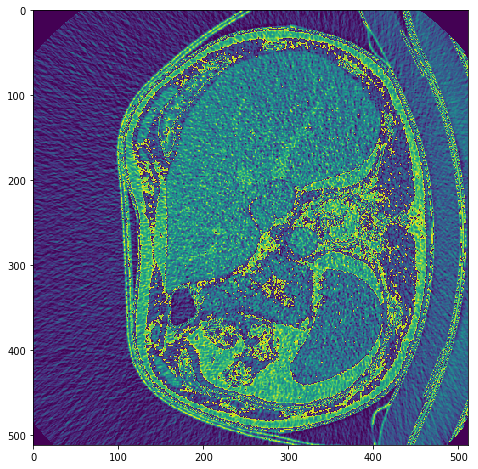

In [111]:
import matplotlib.pyplot as plt
path = os.path.join(ROOT, 'train', '{}', '{}')
img_id = '0096_0589.npy'
X = np.load(path.format('volume', img_id))
y = np.load(path.format('segmentation', img_id))
plt.figure(figsize=(8,8))
plt.imshow(X)

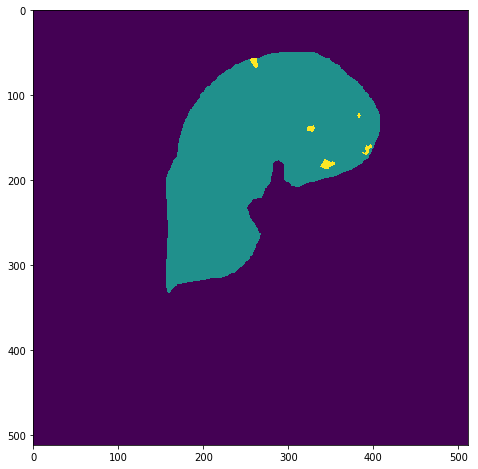

In [112]:
plt.figure(figsize=(8,8))
plt.imshow(y)

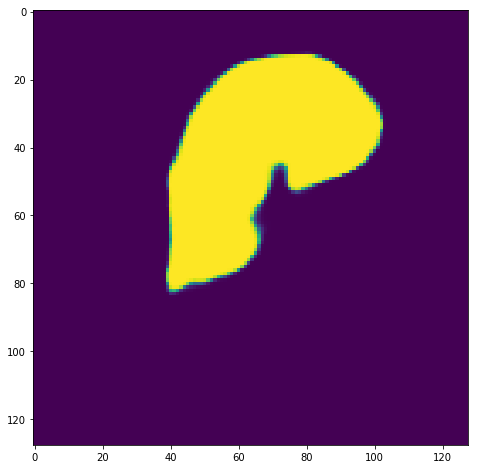

In [114]:
y_pred = model.predict(X[np.newaxis,::4,::4,np.newaxis])
plt.figure(figsize=(8,8))
plt.imshow(y_pred.reshape(128,128))

a good result from test set

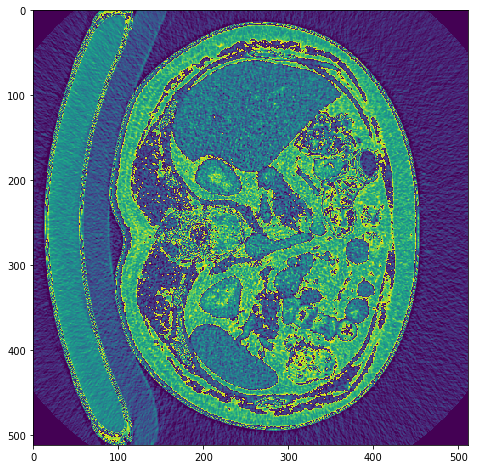

In [122]:
path = os.path.join(ROOT, 'test', '{}', '{}')
img_id = '0010_0359.npy'
X = np.load(path.format('volume', img_id))
y = np.load(path.format('segmentation', img_id))
plt.figure(figsize=(8,8))
plt.imshow(X)

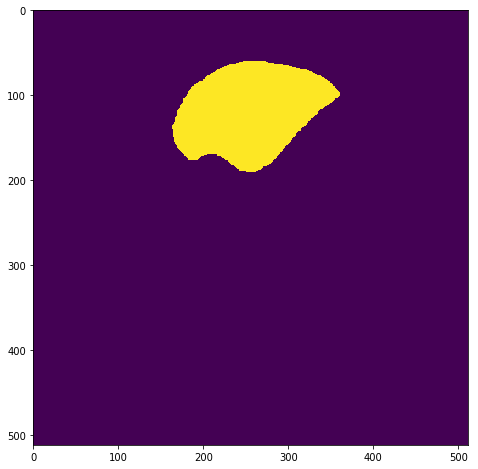

In [123]:
plt.figure(figsize=(8,8))
plt.imshow(y)

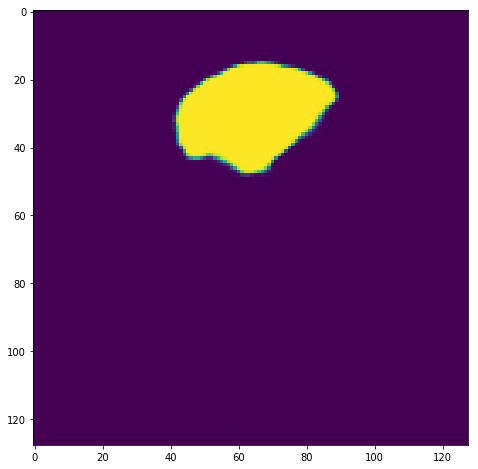

In [124]:
y_pred = model.predict(X[np.newaxis,::4,::4,np.newaxis])
plt.figure(figsize=(8,8))
plt.imshow(y_pred.reshape(128,128))